In [1]:
import importlib
import sys
import datetime as dt
from glob import glob
import itertools

import xarray as xr
import numpy as np
import pandas as pd
from math import nan
import math

import metpy.calc as mpcalc
from metpy.units import units
import metpy

from CASutils import mapplot_utils as maps
from CASutils import filter_utils as filt 

from cmocean import cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

from matplotlib.lines import Line2D
from matplotlib import colors
import matplotlib.patches as mpatches

importlib.reload(maps)
importlib.reload(filt)

<module 'CASutils.filter_utils' from '/home/dhruv/CASanalysis/CASutils/filter_utils.py'>

In [2]:
t2m_files = ["/home/data/ERA5/day/T2m_day/t2m_{}.nc".format(i) for i in range(1979, 2020)]
t2m = xr.open_mfdataset(t2m_files).load()

In [4]:
def jja_std_anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    jja_std = anoms.sel(time=anoms['time.season']=='JJA').std()
    std_anoms = anoms/jja_std
    return std_anoms

In [5]:
def anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    return anoms

In [35]:
def remove_time_mean(x):
    return(x - x.sel(time=x['time.season']=='JJA').mean(dim='time'))

def remove_summer_mean(x):
    return x.groupby('time.year').map(remove_time_mean)

# def remove_time_mean(x):
#     return(x - x.mean(dim='time'))

# def remove_summer_mean(x):
#     return x.groupby('time.year').map(remove_time_mean)

# def remove_summer_mean(x):
#     return(x)

In [7]:
ps_files = ["/home/data/ERA5/PS_day/ps_{}.nc".format(i) for i in range(1979, 2020)]
ps = xr.open_mfdataset(ps_files)

In [8]:
t_files = glob('/home/dhruv/data/temp_ps/*/*.nc')
t = xr.open_mfdataset(t_files)
levels = t.level.data

In [9]:
lblue_coords = [(45, -116), (51, -101), (42, -98), (44, -91), (59, -74)]
pink_coords = [(53, -123), (40.5, -109), (29, -106), (32, -96), (34, -86)]
red_coords = [(62, -129), (54, -121), (56.5, -111), (39, -81), (43, -73)]
dblue_coords = [(41.5, -120.5), (36, -116.5), (37, -101.5), (57.5, -99.5), (50, -92)]

In [10]:
for i, (lat, lon) in enumerate(lblue_coords):
    print(i, lat, lon)

0 45 -116
1 51 -101
2 42 -98
3 44 -91
4 59 -74


In [11]:
ps

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 14975)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Data variables:
    ps       (time, lat, lon) float64 dask.array<chunksize=(365, 192, 288), meta=np.ndarray>

In [12]:
flux_anoms = xr.open_dataset("/home/dhruv/data/heatwave_anoms.nc")

all_lats = flux_anoms.lat.data
all_lons = flux_anoms.lon.data
lats = []
lons = []
corr = [] # 'a' =  ++ , 'b' = '+-' , 'c' ='-+' , d='--' (assum shflx first)
for lat in all_lats:
    for lon in all_lons:
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(1)
            else:
                corr.append(.5)
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()<0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(-.5)
            else:
                corr.append(-1)
        lats.append(lat)
        lons.append(lon)

era_corr_df = pd.DataFrame({'lat':lats, 'lon':lons, 'corrs':corr})
corr_xr = era_corr_df.set_index(['lat', 'lon']).to_xarray()

In [29]:
def see_patches(coords_list, colors=[], edge='darkgreen', dim=2, lw=5, pretitle=""):
    extent = [-130, -65, 25, 65]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    plt.contourf(corr_xr.lon, corr_xr.lat, corr_xr.corrs, cmap='coolwarm', levels=2)
    plt.colorbar(shrink = 0.5)

    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    c_label = '1'
    for i, color in enumerate(colors):
        for lat, lon in coords_list[i]:
            if lon < 0:
                lon = lon + 360

            ax.add_patch(mpatches.Rectangle(xy=[lon-dim/2, lat-dim/2], width=dim, height=dim, 
                facecolor=color, edgecolor=edge, linewidth=lw, alpha=1,label=c_label, transform=ccrs.PlateCarree()))

            t2m_subset = t2m.loc[dict(lat=slice((lat-dim/2), (lat+dim/2)), lon=slice(lon-dim/2, lon+dim/2))]
            print(t2m_subset.lat.values, t2m_subset.lon.values)
            c_label = str(int(c_label) + 1)

    plt.title(pretitle+'ERA5 Quadrant Graph\n Red = ++, Salmon = +shflx,  Light Blue = +lhflx, Blue= --')

[40.9947644  41.93717277] [238.75 240.  ]
[35.34031414 36.28272251] [242.5  243.75]
[36.28272251 37.22513089] [257.5  258.75]
[57.01570681 57.95811518] [260.   261.25]
[49.47643979 50.41884817] [267.5  268.75]
[44.76439791 45.70680628] [243.75 245.  ]
[50.41884817 51.36125654] [258.75 260.  ]
[41.93717277 42.87958115] [261.25 262.5 ]
[43.82198953 44.76439791] [268.75 270.  ]
[58.90052356 59.84293194] [285.   286.25]
[52.30366492 53.2460733 ] [236.25 237.5 ]
[40.05235602 40.9947644 ] [250.   251.25]
[28.7434555  29.68586387] [253.75 255.  ]
[31.57068063 32.51308901] [263.75 265.  ]
[33.45549738 34.39790576] [273.75 275.  ]
[61.72774869 62.67015707] [230.   231.25]
[53.2460733  54.18848168] [238.75 240.  ]
[56.07329843 57.01570681] [248.75 250.  ]
[38.16753927 39.10994764] [278.75 280.  ]
[42.87958115 43.82198953] [286.25 287.5 ]


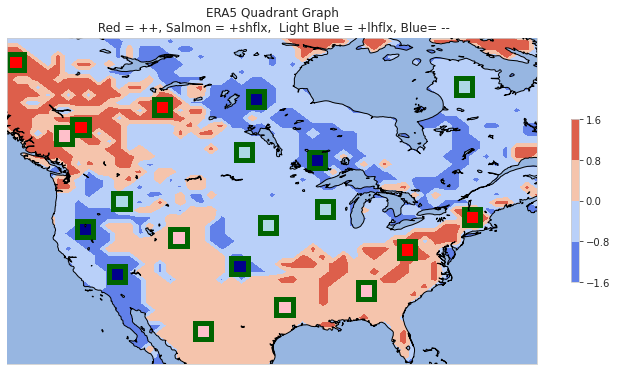

In [30]:
see_patches([dblue_coords, lblue_coords, pink_coords, red_coords], colors=['darkblue', 'lightblue', 'pink', 'red'])

[44.76439791 45.70680628] [243.75 245.  ]
[50.41884817 51.36125654] [258.75 260.  ]
[41.93717277 42.87958115] [261.25 262.5 ]
[43.82198953 44.76439791] [268.75 270.  ]
[58.90052356 59.84293194] [285.   286.25]


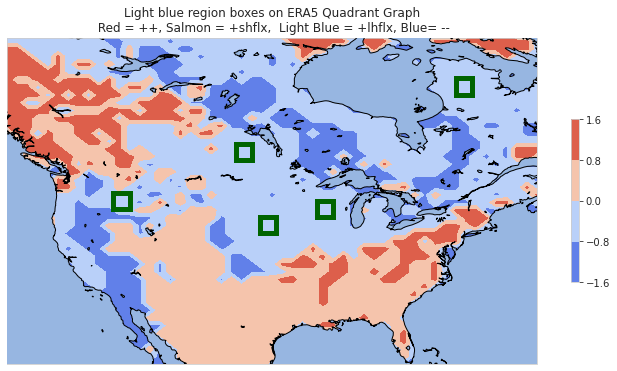

In [5]:
lblue_coords = [(45, -116), (51, -101), (42, -98), (44, -91), (59, -74)]
see_patches(lblue_coords , pretitle="Light blue region boxes on ")

In [31]:
def pt_box_anoms_vp(coords, title, dim=2): 
    fig, ax = plt.subplots(3, 5, figsize = (28, 18))
        
    for col, (lat, lon) in enumerate(coords):
        if lon < 0:
            lon = lon + 360

        t2m_region = t2m.loc[dict(lat=slice((lat-dim/2), (lat+dim/2)), lon=slice(lon-dim/2, lon+dim/2))]
        
        # get JJA temperature anomalies
        t2m_data = t2m_region.t2m.mean(dim=('lat','lon'))
        t2m_anoms = remove_annual_mean(jja_std_anoms(t2m_data))
        jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
        
        heatwave_days3 = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
        heatwave_days1 = heatwave_days3 - np.timedelta64(5,'D')
        heatwave_days2 = heatwave_days3 - np.timedelta64(3,'D')

        hws = [heatwave_days1,heatwave_days2,heatwave_days3]

        titles = [title + ' Five Days Before HW',
                 title+ ' Three Days Before HW',
                 title + ' During HW']

        arr1, arr2 = t2m_region.lat.data, t2m_region.lon.data
        combos = []
        for i in range(len(arr1)):
            for j in range(len(arr2)):
                combos.append([arr1[i],arr2[j]])

        num = len(combos)
        print(num)

        surface_pressures = []
        for i in range(num):
            lat = combos[i][0]
            lon = combos[i][1]
            sp = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100
            surface_pressures.append(sp)

        colors = ['peru', 'lightcoral', 'dodgerblue', 'forestgreen']

        df = pd.DataFrame(np.nan, index= np.arange(num),columns= levels)

        tp_pot_anoms = dict()

        for j in range(3):
            print("J = "+str(j))
            current_hw = hws[j]
            for i in range(num):
                tp_pot_anoms = dict()
                for level in levels:
                    if level > surface_pressures[i]:
#                         break
                        tp_pot_anoms[level] = nan
                        continue
                    # find temp at specific lat,lon,lev
                    t_level = t.sel(level=level).sel(dict(lat=combos[i][0], lon=combos[i][1]), method='nearest').T.load()
                    t_level_anoms = remove_annual_mean(anoms(t_level))
                    t_pot_anoms = t_level_anoms*(1000./level)**(0.286)
                    tp_pot_anoms[level] = t_pot_anoms.sel(time=current_hw).mean().compute().item()
                
                t2m_here = t2m.t2m.sel(dict(lat=combos[i][0], lon=combos[i][1]))
                t2m_no_std_anoms = remove_annual_mean(anoms(t2m_here))
                t2m_hw_anomaly = t2m_no_std_anoms.sel(time=current_hw).mean().item()
                
                df.iloc[i,:] = tp_pot_anoms.values()
                print(i)
                ax[j,col].scatter(t2m_hw_anomaly, surface_pressures[i], color=colors[i], marker='*')
                ax[j,col].scatter(tp_pot_anoms.values(), tp_pot_anoms.keys(),color=colors[i],alpha=.4)
                ax[j,col].plot(tp_pot_anoms.values(), tp_pot_anoms.keys(),color=colors[i],alpha=.4)

            ax[j,col].plot(df.mean(),levels,color='black',linewidth=3)
            ax[j,col].scatter(df.mean(),levels,color='black')
            ax[j,col].invert_yaxis()
            ax[j,col].set_title(titles[j])
    
    
    fig.tight_layout()

4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3


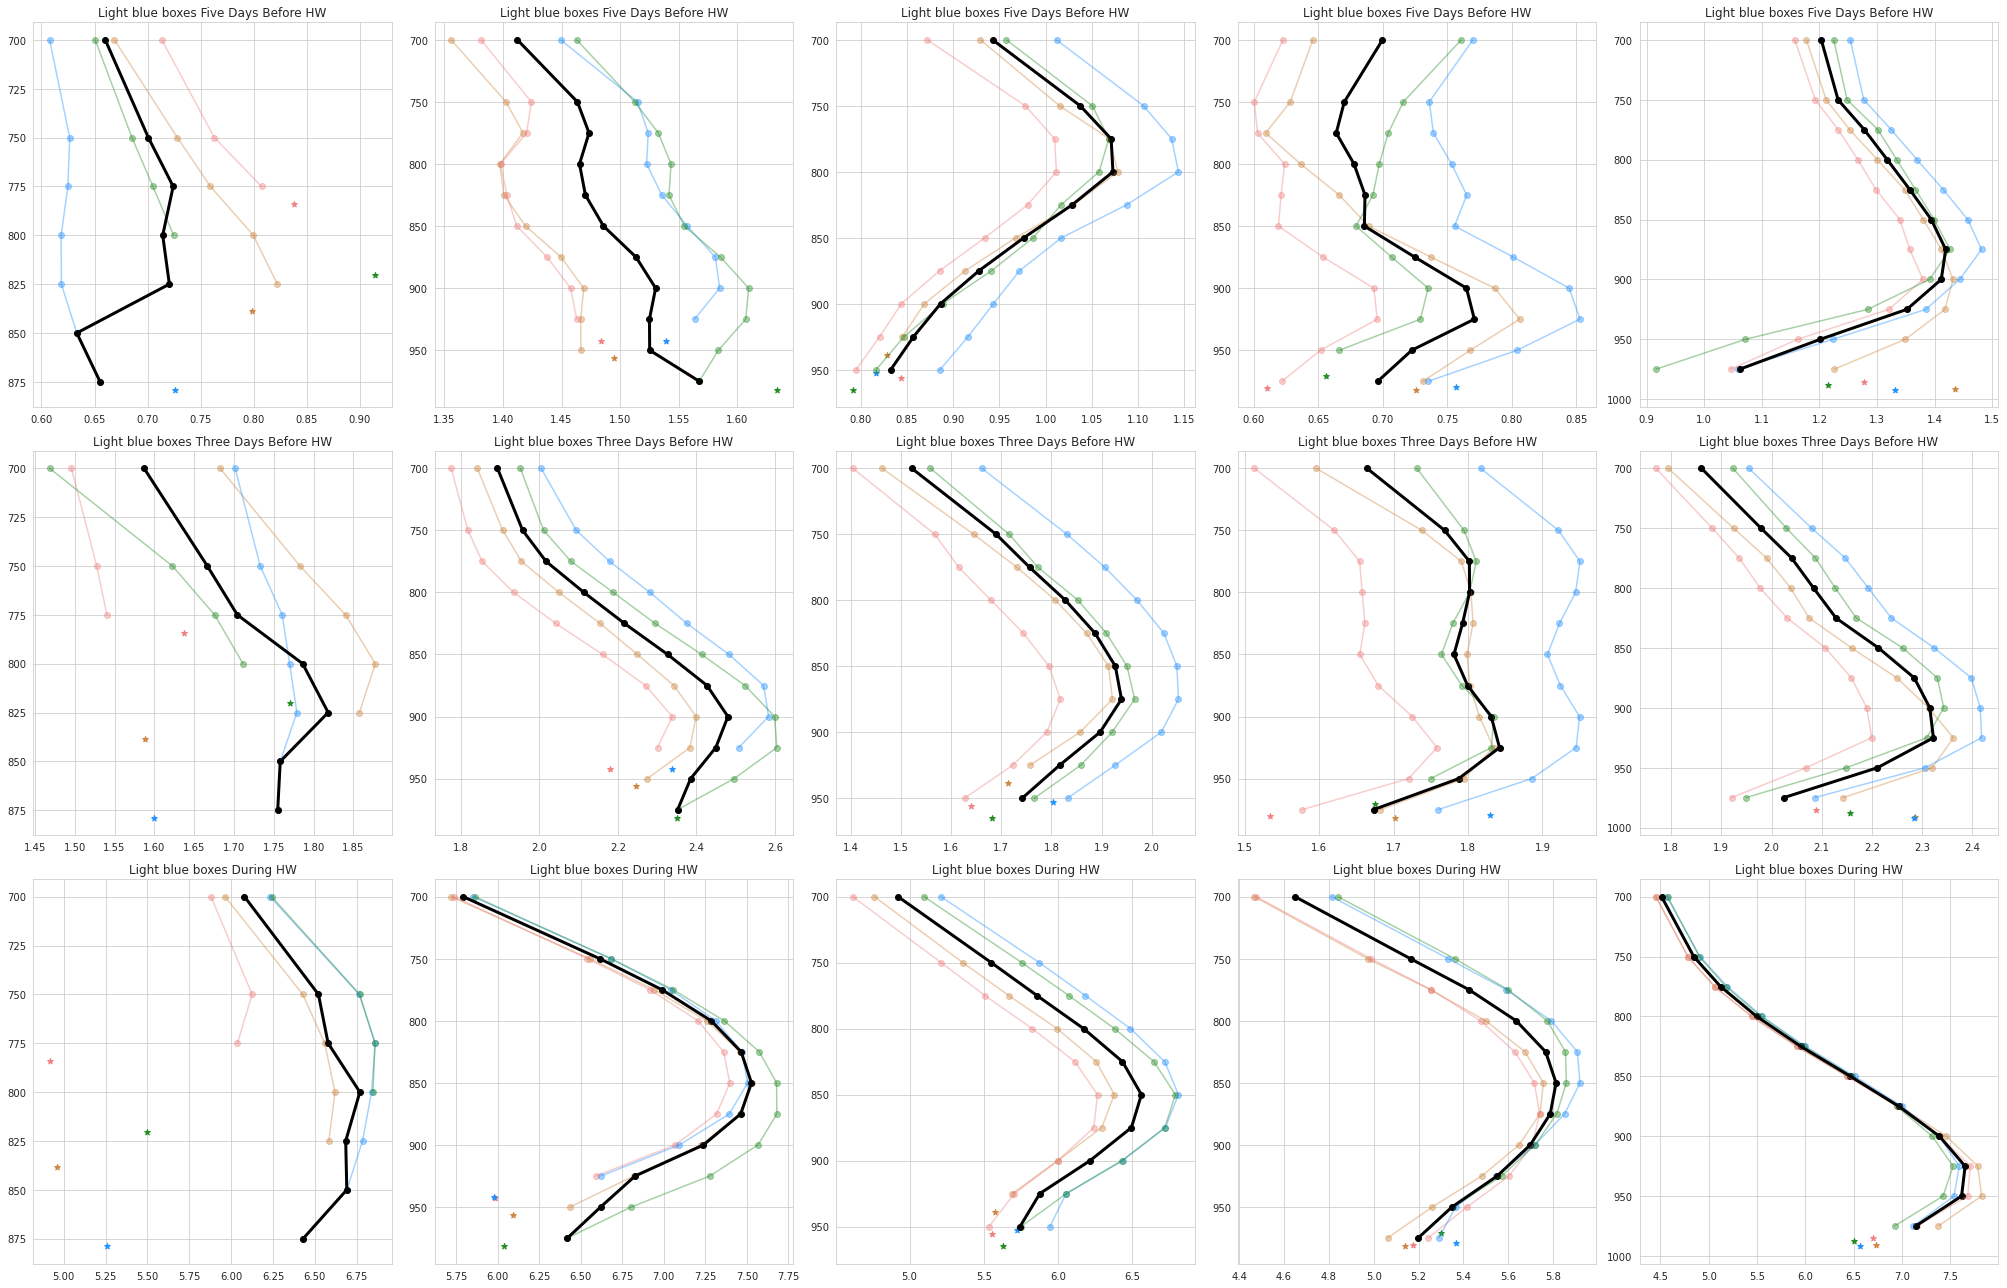

In [25]:
pt_box_anoms_vp(lblue_coords, "Light blue boxes")

[52.30366492 53.2460733 ] [236.25 237.5 ]
[40.05235602 40.9947644 ] [250.   251.25]
[28.7434555  29.68586387] [253.75 255.  ]
[31.57068063 32.51308901] [263.75 265.  ]
[33.45549738 34.39790576] [273.75 275.  ]


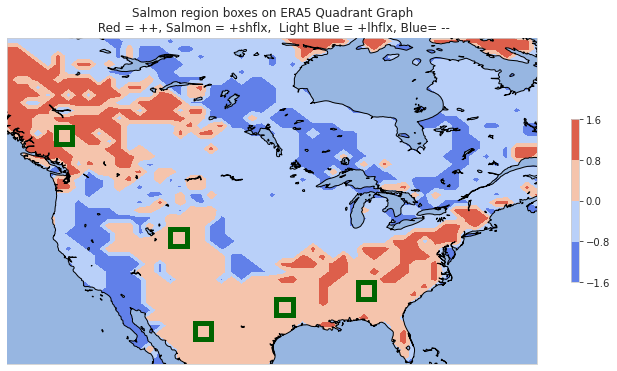

In [11]:
pink_coords = [(53, -123), (40.5, -109), (29, -106), (32, -96), (34, -86)]
see_patches(pink_coords , pretitle="Salmon region boxes on ")

4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3


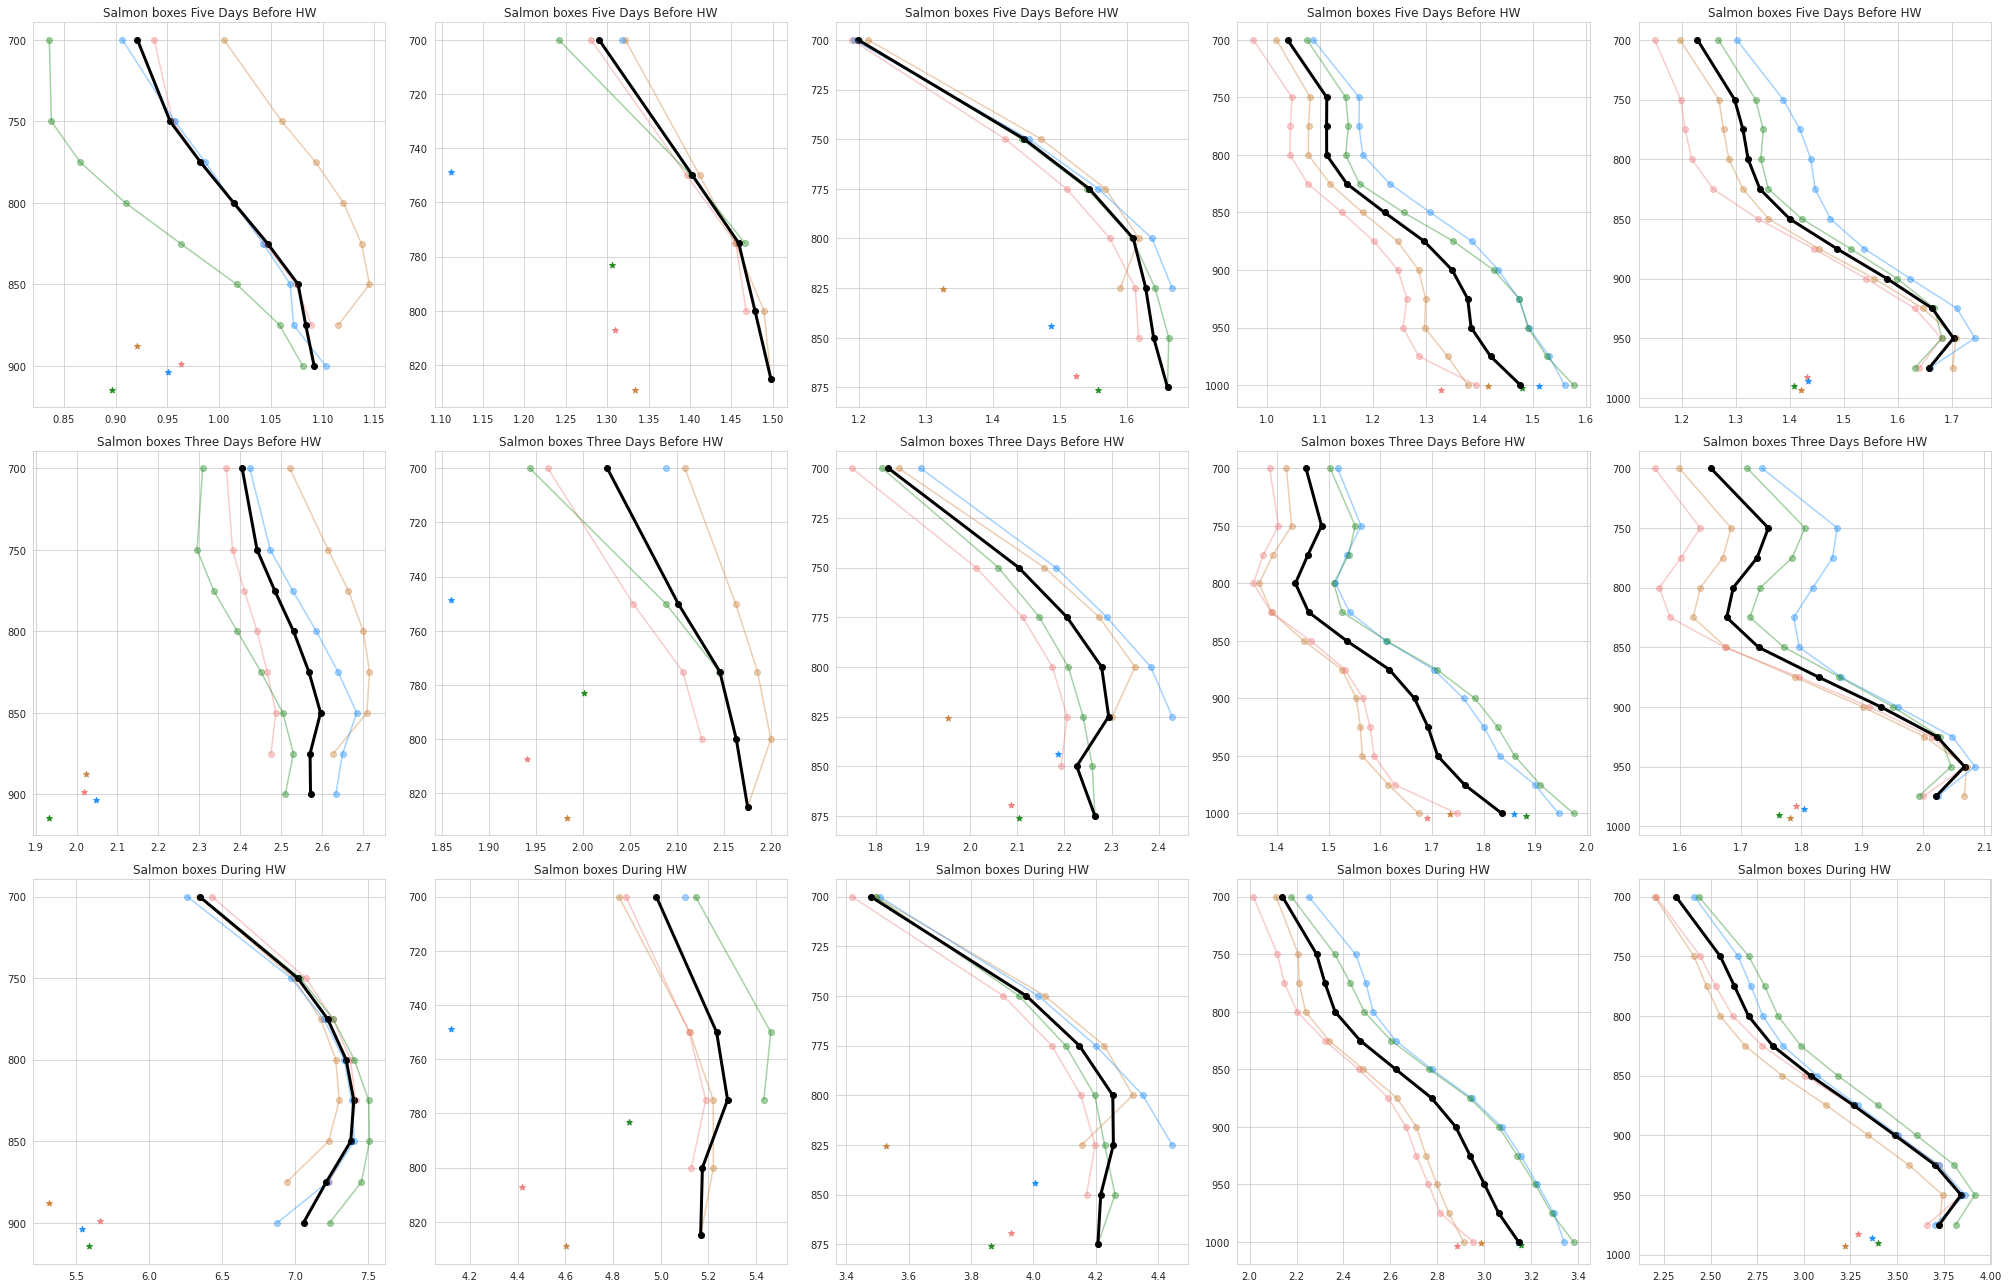

In [84]:
pt_box_anoms_vp(pink_coords, "Salmon boxes")

[61.72774869 62.67015707] [230.   231.25]
[53.2460733  54.18848168] [238.75 240.  ]
[56.07329843 57.01570681] [248.75 250.  ]
[38.16753927 39.10994764] [278.75 280.  ]
[42.87958115 43.82198953] [286.25 287.5 ]


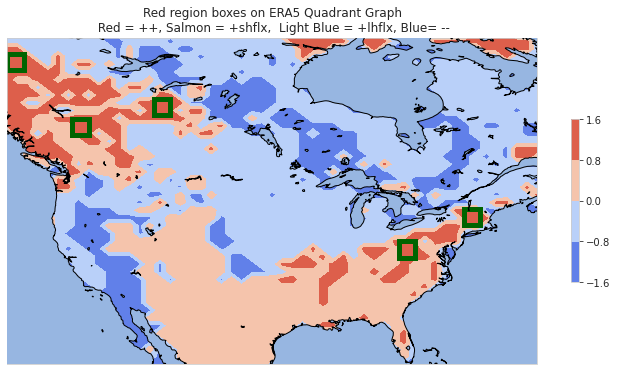

In [12]:
red_coords = [(62, -129), (54, -121), (56.5, -111), (39, -81), (43, -73)]
see_patches(red_coords , pretitle="Red region boxes on ")

4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3


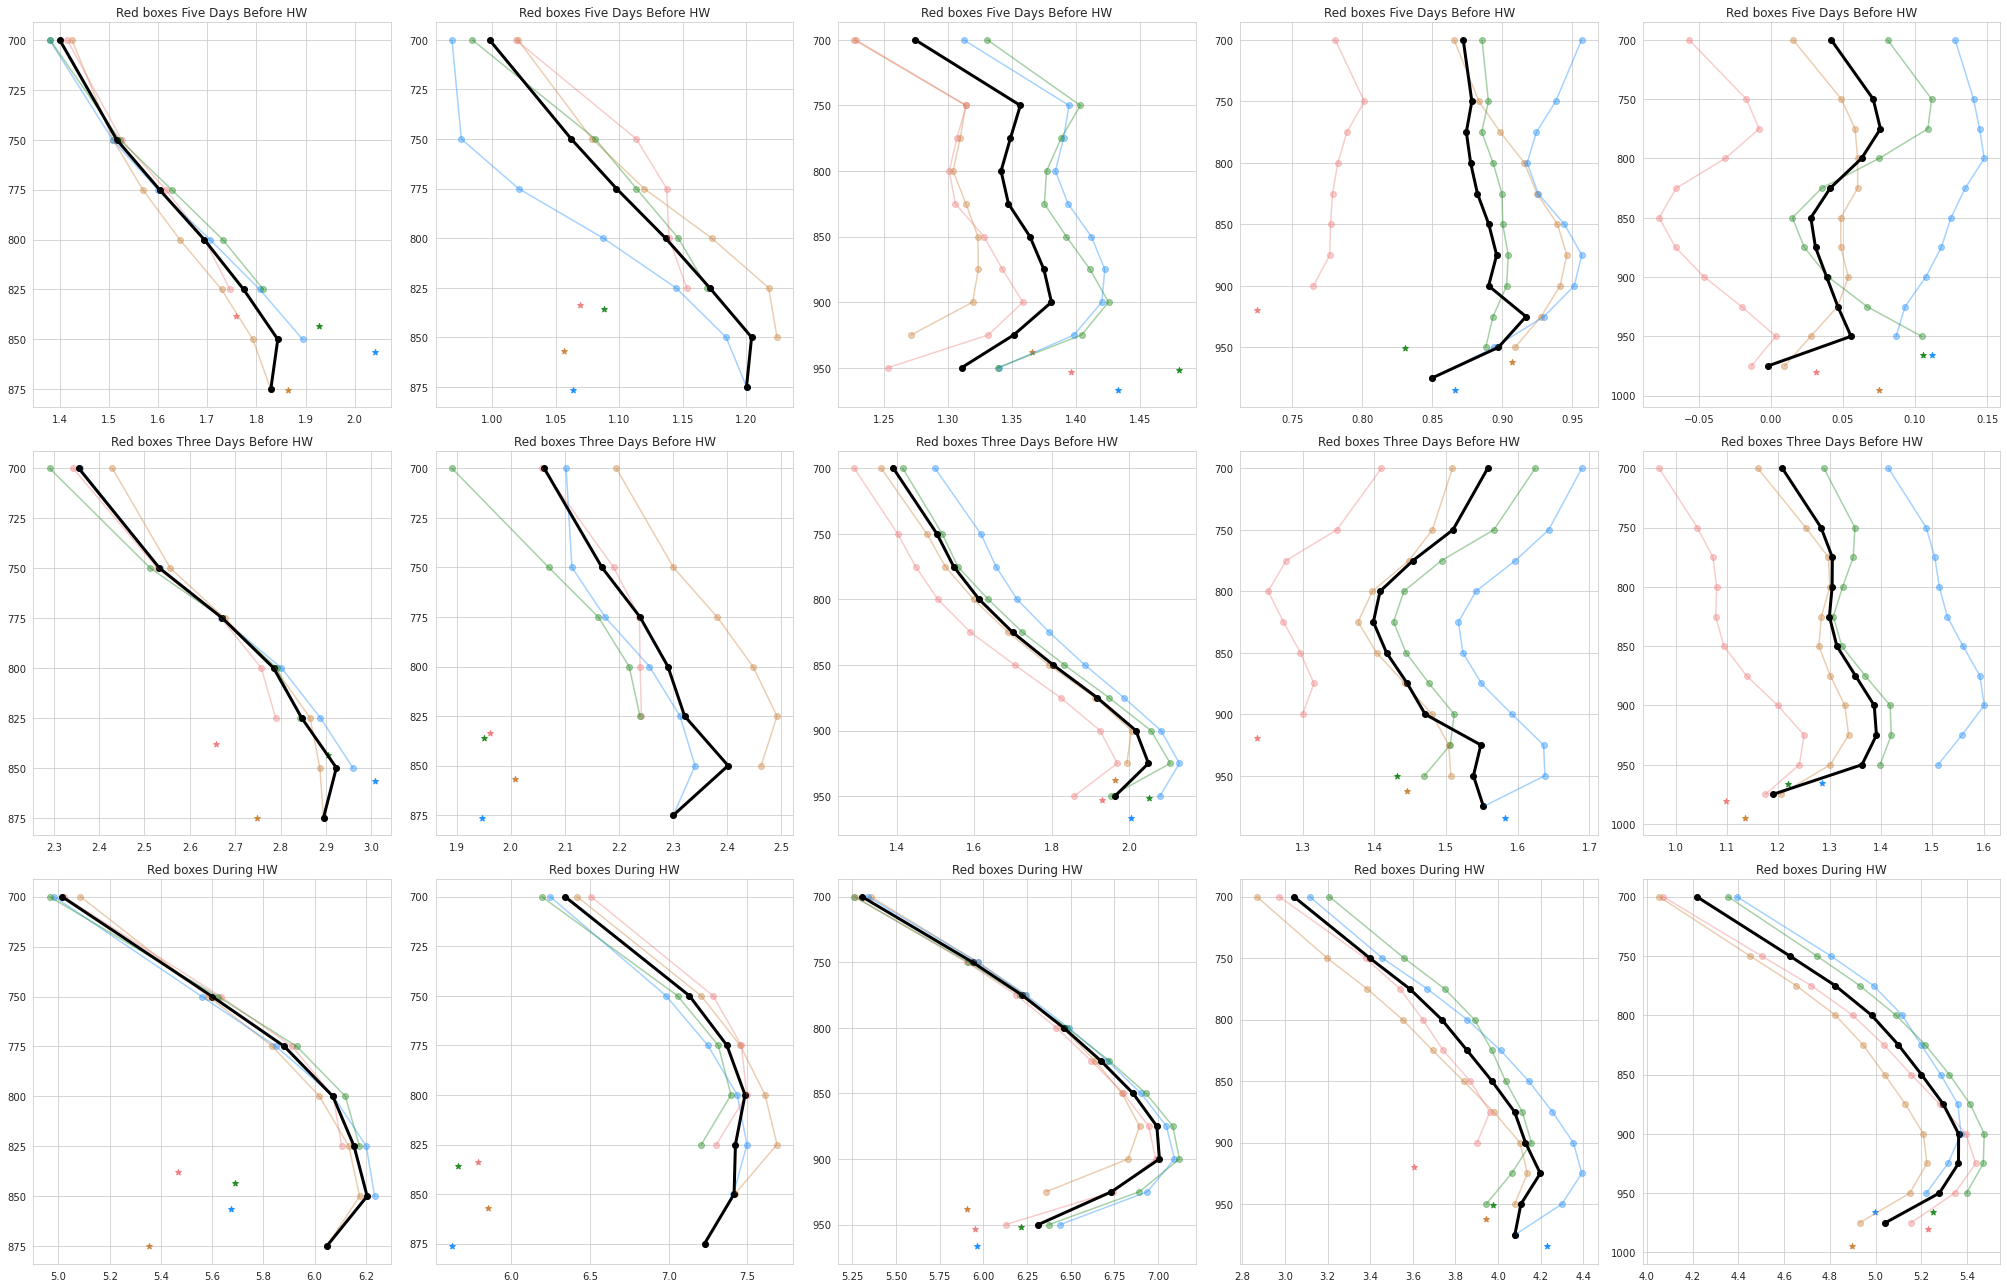

In [85]:
pt_box_anoms_vp(red_coords, "Red boxes")

[40.9947644  41.93717277] [238.75 240.  ]
[35.34031414 36.28272251] [242.5  243.75]
[36.28272251 37.22513089] [257.5  258.75]
[57.01570681 57.95811518] [260.   261.25]
[49.47643979 50.41884817] [267.5  268.75]


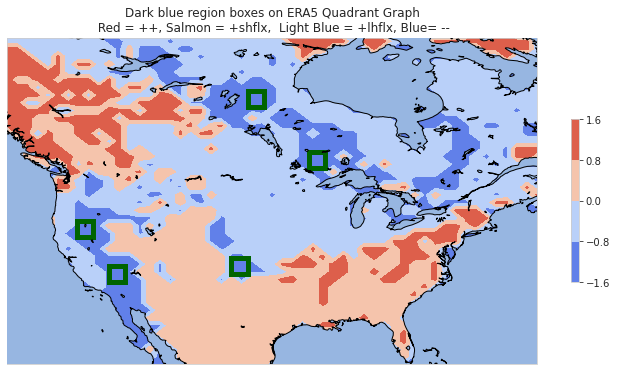

In [13]:
dblue_coords = [(41.5, -120.5), (36, -116.5), (37, -101.5), (57.5, -99.5), (50, -92)]
see_patches(dblue_coords , pretitle="Dark blue region boxes on ")

4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3
4
J = 0
0
1
2
3
J = 1
0
1
2
3
J = 2
0
1
2
3


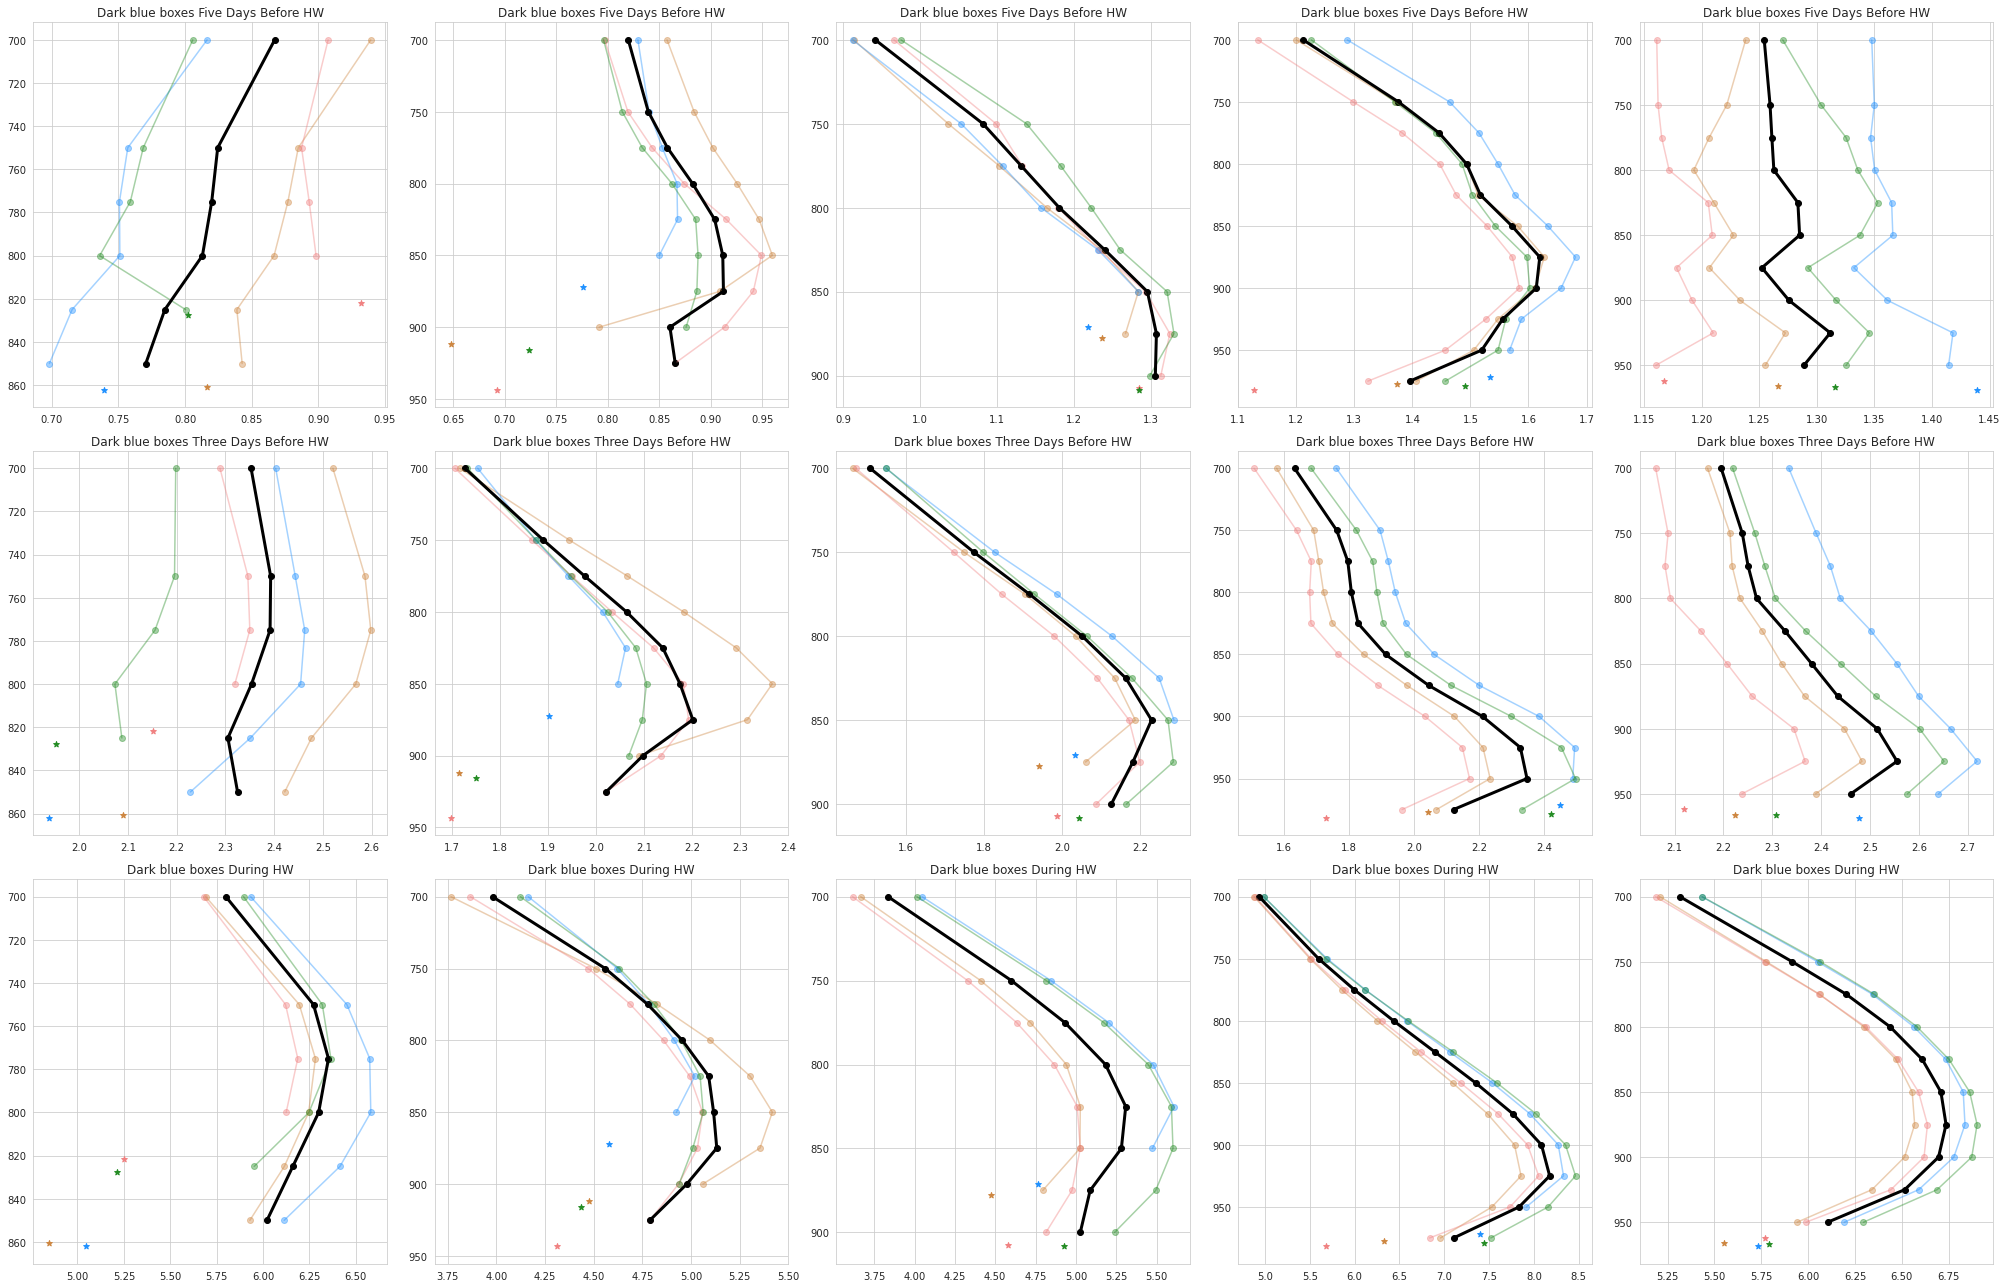

In [86]:
pt_box_anoms_vp(dblue_coords, "Dark blue boxes")

In [15]:
def get_heatwavedays(t2m):    
    t2m_anoms = remove_summer_mean(jja_std_anoms(t2m))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    return(heatwave_days)

In [16]:
def get_temperature_anoms(t_data):
#     if ~np.isnan(t_data.mean().item()):
    anomalies = remove_summer_mean(anoms(t_data))
#     anoms = xr.where()
    return(anomalies)
#     else: 
#         return(np.nan)

In [24]:
def gather_anoms(c_lat, c_lon):
    if c_lon < 0:
        c_lon = 360 + c_lon
        
    all_anoms = []
    hwdays = get_heatwavedays(t2m.t2m.sel(dict(lat=c_lat, lon=c_lon), method='nearest'))
    sp = ps.ps.sel(dict(lat=c_lat, lon=c_lon), method='nearest').mean().compute().item()/100
    
    for i in np.arange(len(levels)): 
        if levels[i] > sp:
            all_anoms.append(np.nan)
            continue
        temp = t.sel(dict(lat=c_lat,lon=c_lon,level=levels[i]),method='nearest').load()
        catch_anoms = get_temperature_anoms(temp.T)
        all_anoms.append(catch_anoms)
        
    return(all_anoms, hwdays, sp)

In [18]:
def mesh_plot(df,hw_days,t2m_anoms,cmap='YlOrRd',title='',fill='auto'):

    lat = df.iloc[0,1].lat.item()
    lon = df.iloc[0,1].lon.item()
    surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
    temp_anoms = list(df['temp_anoms'])
    levels = list(df['levels'])
    days = np.arange(-5,3)

    ddff = pd.DataFrame(np.nan, index=levels, columns=np.arange(-5,3))
    
    for lev in range(len(levels)):
        
        pressure = levels[lev]
        data = pd.Series(np.nan,index=days)
        tp_anoms = temp_anoms[lev]*(1000/pressure)**(0.286)
        
        for i in np.arange(len(days)): # for day before / after heatwave
            
            day = days[i]
            data[day] = tp_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()

           
        ddff.iloc[lev,:] = data.values
            
      
    
    data = pd.Series(np.nan,index=days)
    for i in np.arange(len(days)):
        day = days[i]
        data[day] = t2m_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
        
    save_ind = np.array(ddff.index)
    new_ind = np.insert(save_ind,[0], (surface_pressure+20))
    ddff = ddff.iloc[::-1]
    ddff = ddff.append(data, ignore_index=True)
    ddff = ddff.set_index(new_ind[::-1])
    ddff = ddff.sort_index(ascending=True)
    ddff = ddff.dropna()
    
#     sds = ddff.std(axis=1)
#     display(sds)
#     meanz = ddff.mean(axis=1)
#     display(meanz)
    
#     for i in np.arange(len(sds)):
#         name = ddff.iloc[i,:].name
#         display(name)
#         display(ddff.iloc[i,:])
#         ddff.iloc[i,:] = (ddff.iloc[i,:]-meanz[name])/sds[name]
#         display(ddff.iloc[i,:])

#     display(ddff)
#     display(ddff.mean())
#     display(ddff.std())
    ddff = (ddff-ddff.mean())/ddff.std()
    
#     ddff = ddff.apply(lambda x: x/x.max(), axis=1)

    
    plt.pcolormesh(np.array(ddff.columns),np.array(ddff.index) , ddff,  cmap =cmap ,shading=fill)
    
    plt.ylim(ddff.index[0], ddff.index[-1])
    plt.gca().invert_yaxis()

    plt.colorbar(shrink=.75) 
    plt.title('ERA5 Potential Temperature Anomalies Non-Standardized at {}, {}'.format(lat,lon)+title)
    plt.xlabel('Days Around HW')
    plt.ylabel('Height (hPa)')

In [15]:
def mesh_plot_norm_by_sp(df,hw_days,t2m_anoms,cmap='YlOrRd',title='',fill='auto'):

    lat = df.iloc[0,1].lat.item()
    lon = df.iloc[0,1].lon.item()
    surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
    temp_anoms = list(df['temp_anoms'])
    levels = list(df['levels'])
    days = np.arange(-5,3)

    ddff = pd.DataFrame(np.nan, index=levels, columns=np.arange(-5,3))
    
    for lev in range(len(levels)):
        
        pressure = levels[lev]
        data = pd.Series(np.nan,index=days)
        tp_anoms = temp_anoms[lev]*(1000/pressure)**(0.286)
        
        for i in np.arange(len(days)): # for day before / after heatwave
            
            day = days[i]
            data[day] = tp_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()

           
        ddff.iloc[lev,:] = data.values
            
      
    
    data = pd.Series(np.nan,index=days)
    for i in np.arange(len(days)):
        day = days[i]
        data[day] = t2m_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
        
    save_ind = np.array(ddff.index)
    new_ind = np.insert(save_ind,[0], (surface_pressure+20))
    ddff = ddff.iloc[::-1]
    ddff = ddff.append(data, ignore_index=True)
    ddff = ddff.set_index(new_ind[::-1])
    ddff = ddff.sort_index(ascending=True)
    ddff = ddff.dropna()
    
    ddff = ddff.div(ddff.iloc[-1])
    
    plt.pcolormesh(np.array(ddff.columns),np.array(ddff.index) , ddff,  cmap =cmap ,shading=fill)
    
    plt.ylim(ddff.index[0], ddff.index[-1])
    plt.gca().invert_yaxis()

    plt.colorbar(shrink=.75) 
    plt.title('ERA5 Potential Temperature Anomalies Non-Standardized at {}, {}'.format(lat,lon)+title)
    plt.xlabel('Days Around HW')
    plt.ylabel('Height (hPa)')

In [32]:
def mesh_plot3(df,hw_days,t2m_anoms,title='',fill='auto'):

    lat = df.iloc[0,1].lat.item()
    lon = df.iloc[0,1].lon.item()
    surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
    print("Surface Pressure: " + str(surface_pressure))
    temp_anoms = list(df['temp_anoms'])
    levels = list(df['levels'])
    days = np.arange(-5,3)

    ddff = pd.DataFrame(np.nan, index=levels, columns=np.arange(-5,3))
    
    for lev in range(len(levels)):
        
        pressure = levels[lev]
        data = pd.Series(np.nan,index=days)
        tp_anoms = temp_anoms[lev]*(1000/pressure)**(0.286)
        
        for i in np.arange(len(days)): # for day before / after heatwave
            
            day = days[i]
            data[day] = tp_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()

           
        ddff.iloc[lev,:] = data.values
            
      
    
    data = pd.Series(np.nan,index=days)
    for i in np.arange(len(days)):
        day = days[i]
        data[day] = t2m_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
   # return(data)
        
    save_ind = np.array(ddff.index)
    new_ind = np.insert(save_ind,[0], (surface_pressure))
    ddff = ddff.iloc[::-1]
    ddff = ddff.append(data, ignore_index=True)
    ddff = ddff.set_index(new_ind[::-1])
    ddff = ddff.sort_index(ascending=True)
    ind = ddff.index <=surface_pressure
    ddff = ddff.iloc[ind,:]
    
    lastrow = ddff.iloc[len(ddff)-1,:]
    ddff = ddff / lastrow
    
    widths = [20, 1]
    heights = [10, 1]

    fig2 = plt.figure(constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2, width_ratios=widths, height_ratios=heights )
    f2_ax1 = fig2.add_subplot(spec2[0, 0])
    
    f2_ax3 = fig2.add_subplot(spec2[:, 1])

    final_row = np.array((lastrow,np.zeros(8)))
    
    cmap = plt.cm.get_cmap('YlOrRd')
    
    cm = f2_ax1.pcolormesh(np.array(ddff.columns),np.array(ddff.index) , ddff,  cmap =cmap ,shading=fill)
    f2_ax1.set_ylim(ddff.index[0]-14, ddff.index[-1] + 4 )
    f2_ax1.invert_yaxis()
    f2_ax1.axes.xaxis.set_visible(True)
    
    
#     f2_ax2 = fig2.add_subplot(spec2[1, 0])
#     f2_ax2.pcolormesh(np.array(ddff.columns), np.array([surface_pressure,surface_pressure+5]), final_row, cmap=cmap , shading = fill)
#     f2_ax2.set_ylim(surface_pressure-1,surface_pressure)
#     f2_ax2.set_ylabel('SP: '+str(round(surface_pressure)) ,rotation='horizontal',ha='right', va='center')
#     f2_ax2.axes.xaxis.set_ticks([])
#     f2_ax2.axes.yaxis.set_ticks([])

    f2_ax2 = fig2.add_subplot(spec2[1, 0])
    f2_ax2.plot(lastrow.index,lastrow,color='black')
    surface_pressure = surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
    f2_ax2.set_ylabel('SP: '+str(round(surface_pressure)) ,rotation='horizontal',ha='right', va='center')
    f2_ax2.axes.xaxis.set_ticks([])

    fig2.colorbar(cm, cax=f2_ax3)
    f2_ax1.set_title('ERA5 Potential Temperature Anomalies at {}, {}'.format(lat,lon)+title)
    f2_ax2.set_xlabel('Days Around HW')
    f2_ax1.set_ylabel('Height (hPa)')

In [14]:
lat, lon = lblue_coords[0]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 838.5219763443237


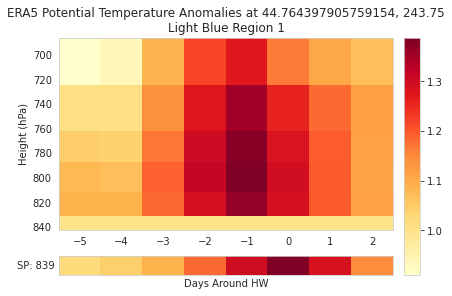

In [46]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1')

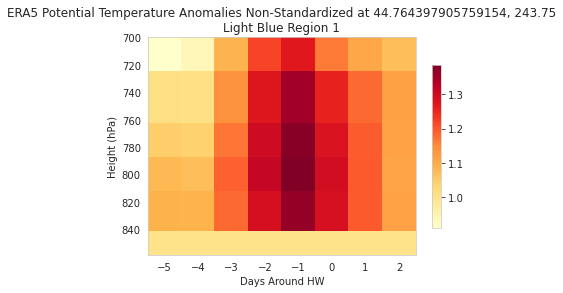

In [16]:
mesh_plot_norm_by_sp(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1')

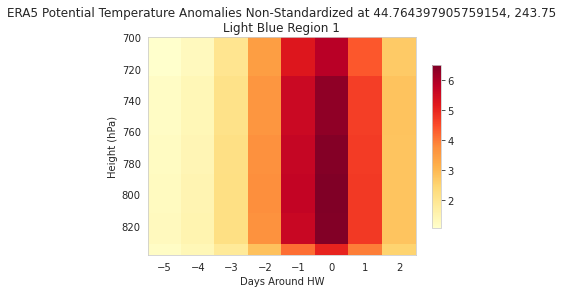

In [52]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1')

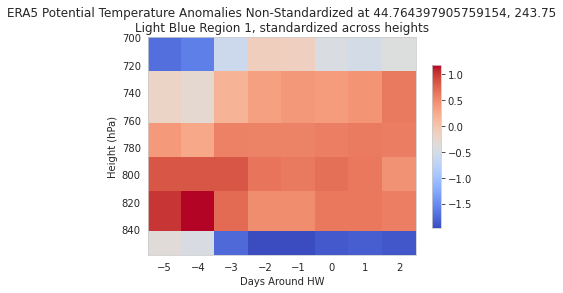

In [19]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1, standardized across heights', cmap='coolwarm')

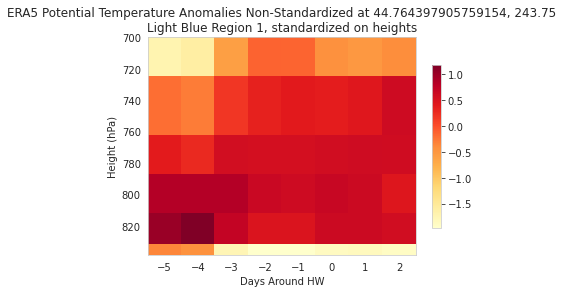

In [57]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1, standardized on heights')

-5        -4        -3        -2        -1         0  \
700.000000  1.086454  1.320241  2.035544  3.496797  5.265808  5.882797   
750.000000  1.205534  1.420369  2.139657  3.658168  5.597349  6.352211   
775.000000  1.251052  1.463470  2.193962  3.732812  5.700024  6.476980   
800.000000  1.286932  1.507043  2.231121  3.767576  5.736465  6.532532   
825.000000  1.300781  1.533093  2.215572  3.708074  5.651577  6.507928   
838.521976  1.193566  1.407721  1.874932  2.866698  4.134870  5.044188   

                   1         2  
700.000000  4.386287  2.713196  
750.000000  4.684472  2.832468  
775.000000  4.741365  2.829404  
800.000000  4.748640  2.813048  
825.000000  4.749843  2.827944  
838.521976  3.964927  2.538829

-5    1.220720
-4    1.441990
-3    2.115131
-2    3.538354
-1    5.347682
 0    6.132773
 1    4.545922
 2    2.759148
dtype: float64

-5    0.078370
-4    0.076756
-3    0.137395
-2    0.342452
-1    0.617673
 0    0.585608
 1    0.317210
 2    0.117134
dtype: float64

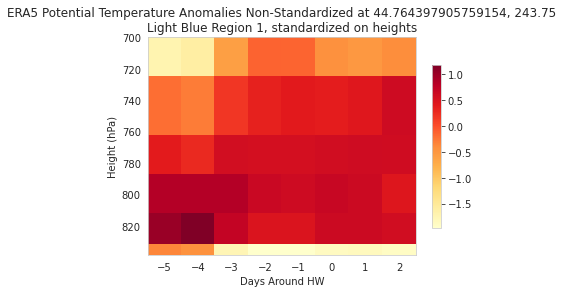

In [59]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1, standardized on heights')

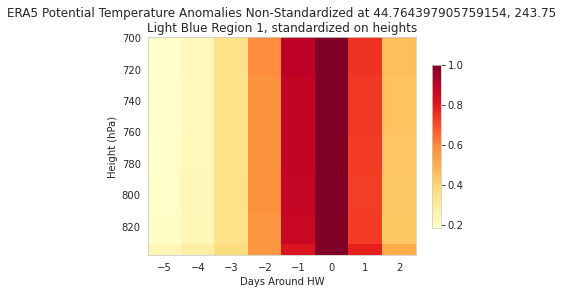

In [53]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 1, standardized on heights')

In [47]:
lat, lon = lblue_coords[1]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 942.3197206518937


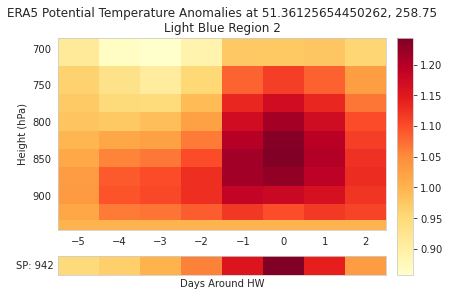

In [48]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 2')

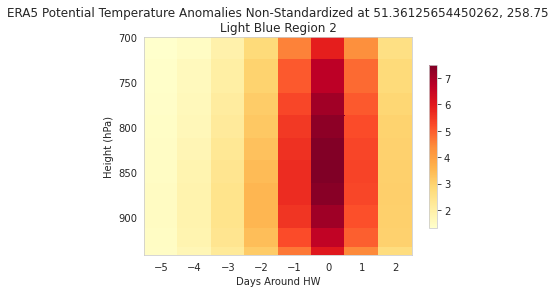

In [56]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 2')

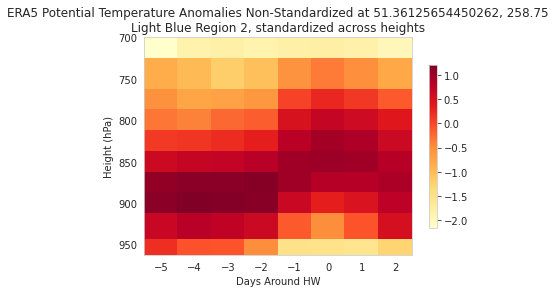

In [21]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 2, standardized across heights')

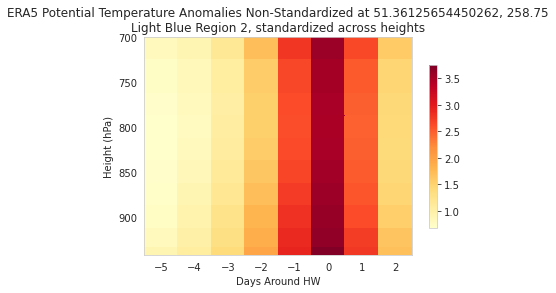

In [27]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 2, standardized across heights')

In [49]:
lat, lon = lblue_coords[2]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 955.9903703100056


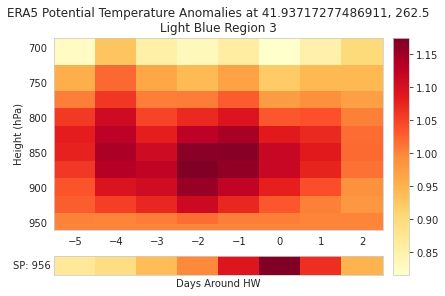

In [50]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 3')

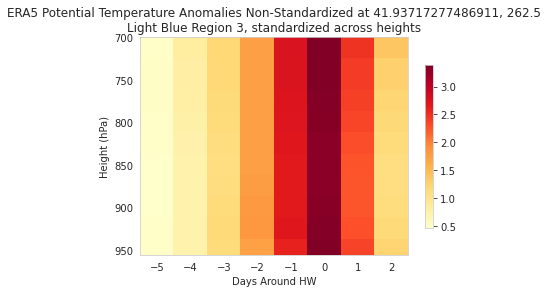

In [30]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 3, standardized across heights')

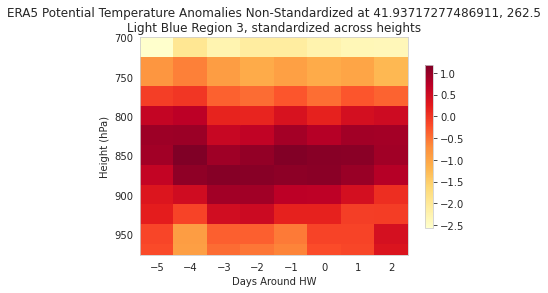

In [23]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 3, standardized across heights')

In [51]:
lat, lon = lblue_coords[3]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 981.6633820106065


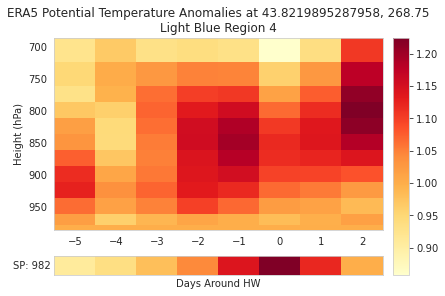

In [52]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 4')

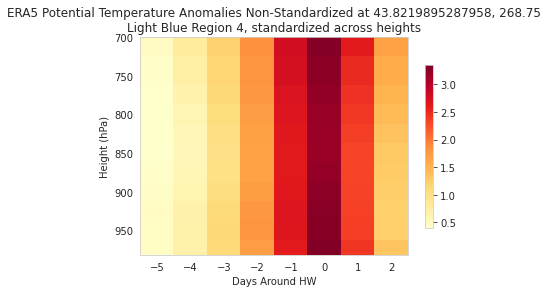

In [32]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 4, standardized across heights')

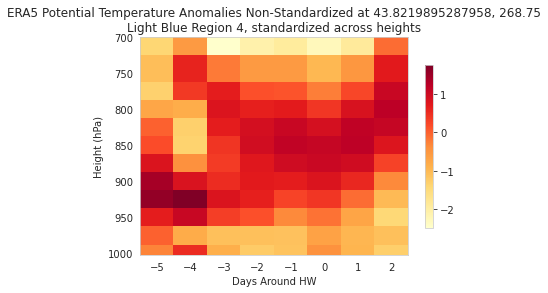

In [25]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 4, standardized across heights')

In [53]:
lat, lon = lblue_coords[4]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

In [ ]:
# mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 5, standardized across heights')

Surface Pressure: 985.3141454538647


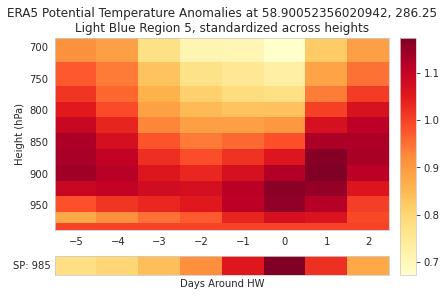

In [54]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 5, standardized across heights')

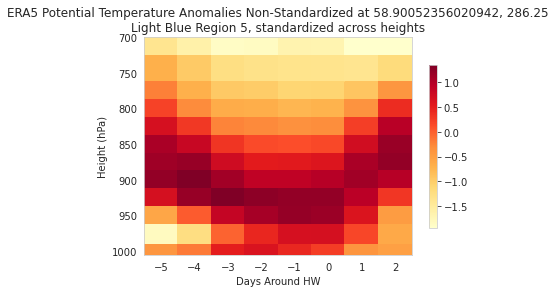

In [27]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nLight Blue Region 5, standardized across heights')

In [55]:
lat, lon = pink_coords[0]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 914.4839139023477


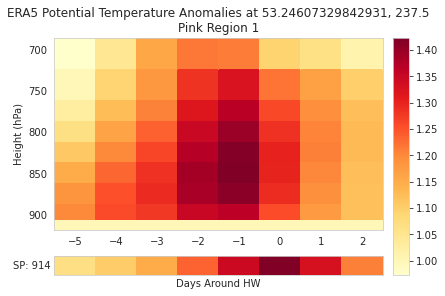

In [56]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 1')

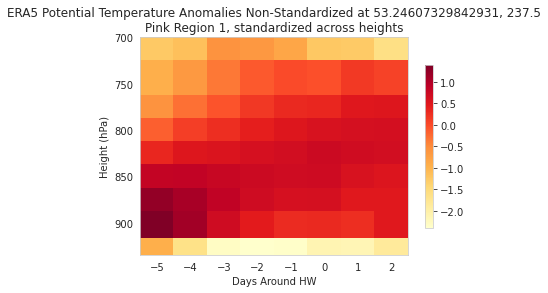

In [29]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 1, standardized across heights')

In [57]:
lat, lon = pink_coords[1]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 807.1943767788475


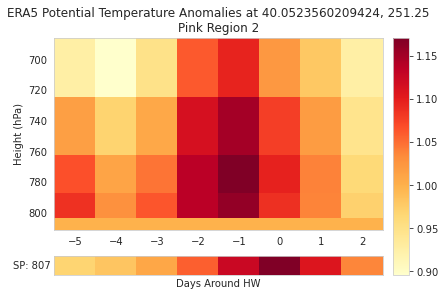

In [58]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 2')

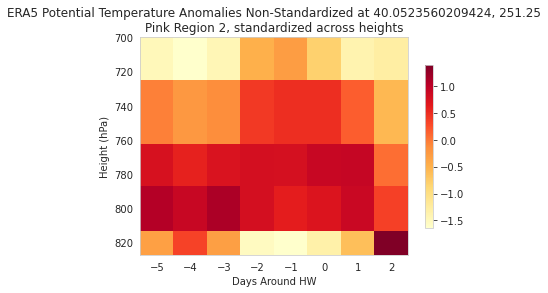

In [31]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 2, standardized across heights')

In [59]:
lat, lon = pink_coords[2]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 825.572960311619


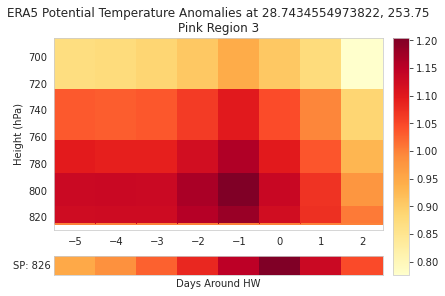

In [60]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 3')

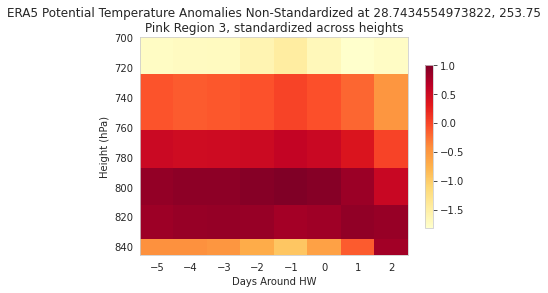

In [33]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 3, standardized across heights')

In [61]:
lat, lon = pink_coords[3]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 1000.7158952435931


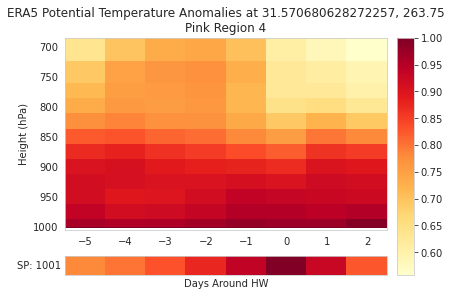

In [62]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 4')

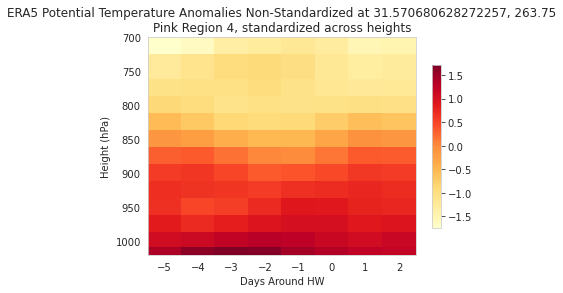

In [35]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 4, standardized across heights')

In [63]:
lat, lon = pink_coords[4]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 985.9539293000547


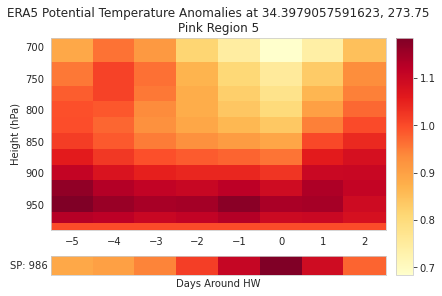

In [64]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 5')

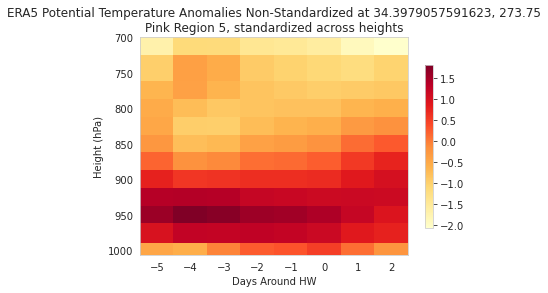

In [37]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nPink Region 5, standardized across heights')

In [65]:
lat, lon = red_coords[0]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 838.0952964566208


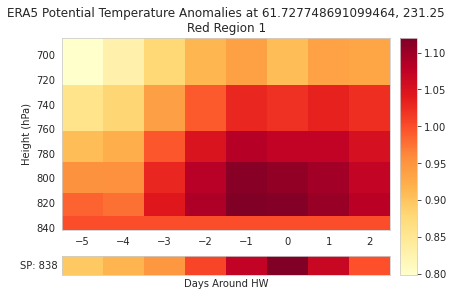

In [66]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 1')

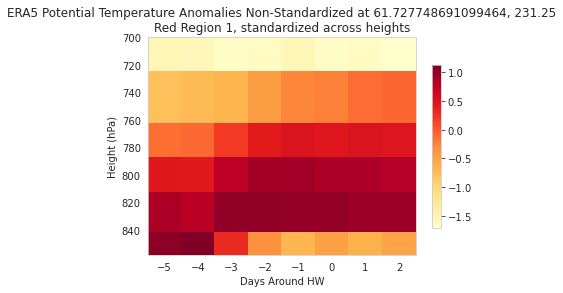

In [39]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 1, standardized across heights')

In [67]:
lat, lon = red_coords[1]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 876.3568825410964


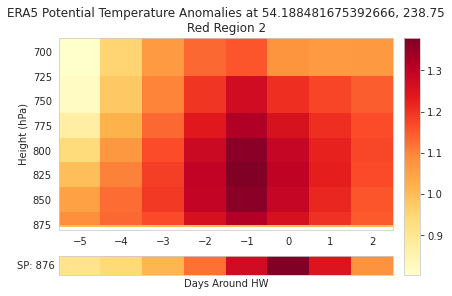

In [68]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 2')

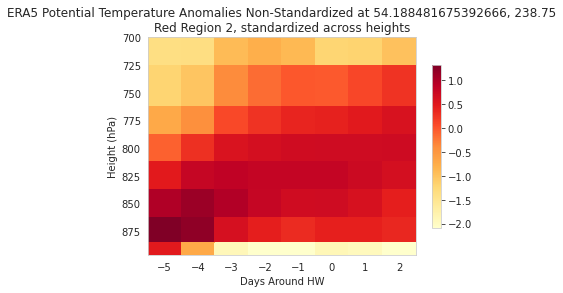

In [41]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 2, standardized across heights')

In [69]:
lat, lon = red_coords[2]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 937.8167519810963


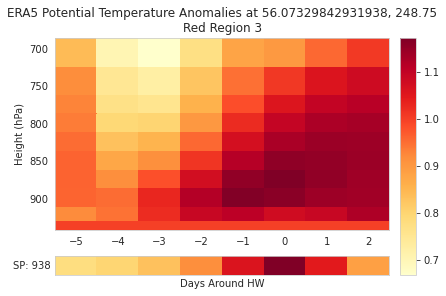

In [70]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 3')

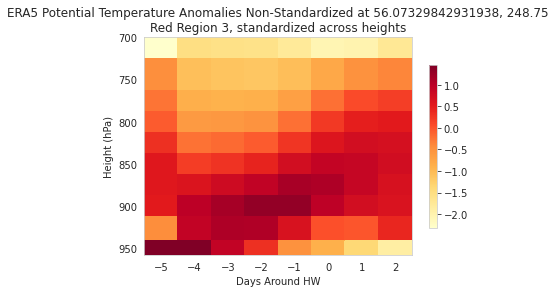

In [43]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 3, standardized across heights')

In [71]:
lat, lon = red_coords[3]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 984.3076660648521


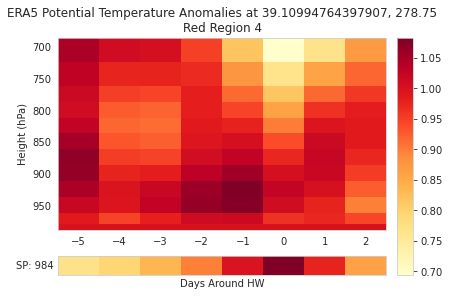

In [72]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 4')

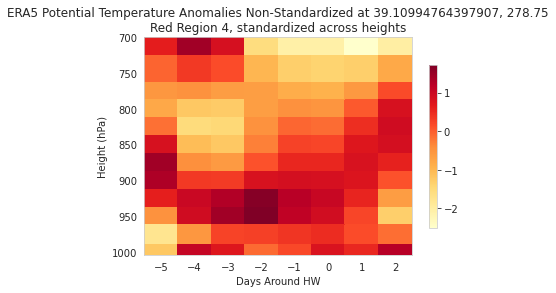

In [45]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 4, standardized across heights')

In [73]:
lat, lon = red_coords[4]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 980.4106550850437


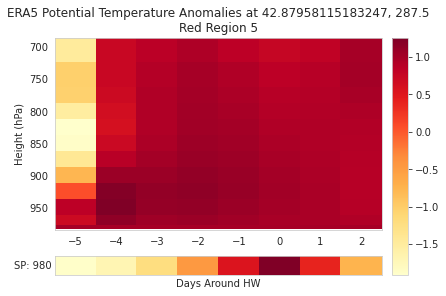

In [74]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 5')

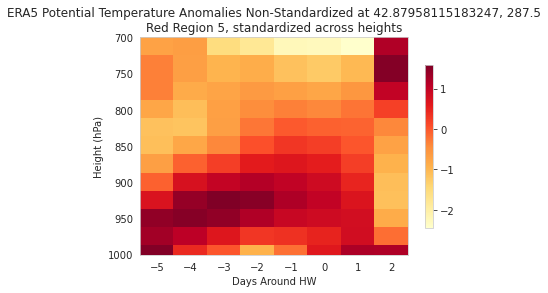

In [47]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nRed Region 5, standardized across heights')

In [75]:
lat, lon = dblue_coords[0]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 827.711228854487


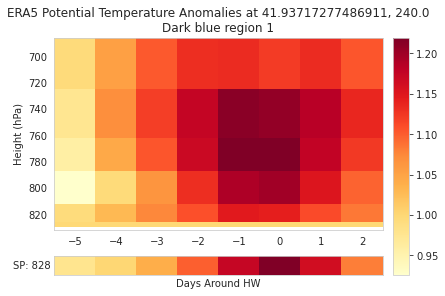

In [76]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 1')

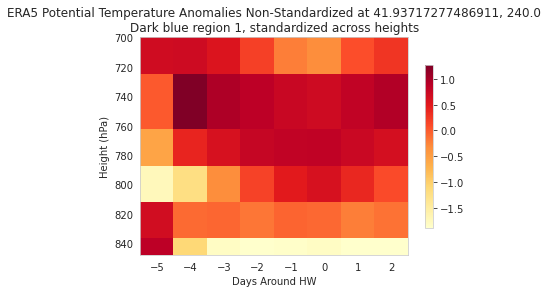

In [49]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 1, standardized across heights')

In [77]:
lat, lon = dblue_coords[1]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 915.9014964767993


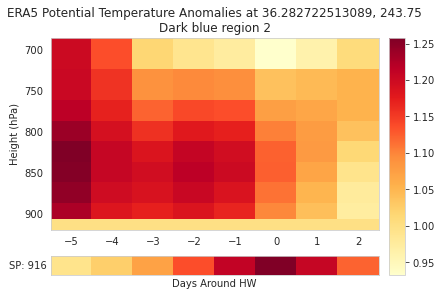

In [78]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 2')

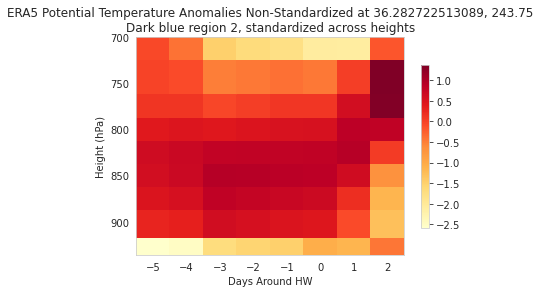

In [51]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 2, standardized across heights')

In [79]:
lat, lon = dblue_coords[2]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 908.2894396494083


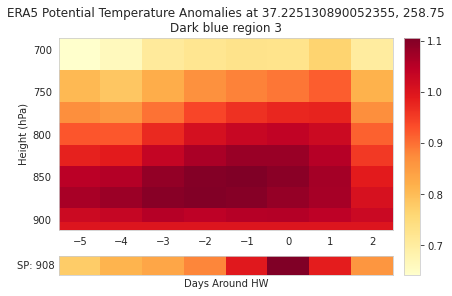

In [80]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 3')

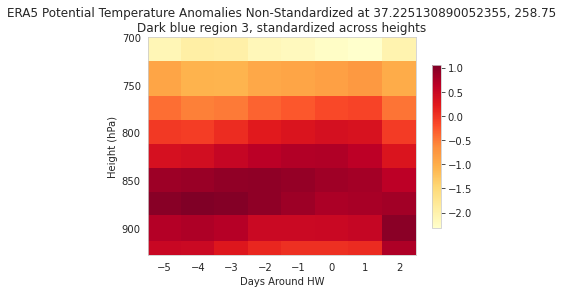

In [53]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 3, standardized across heights')

In [81]:
lat, lon = dblue_coords[3]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 971.4847862287381


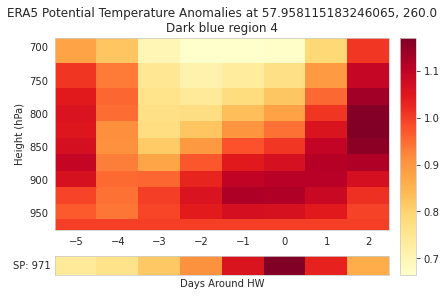

In [82]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 4')

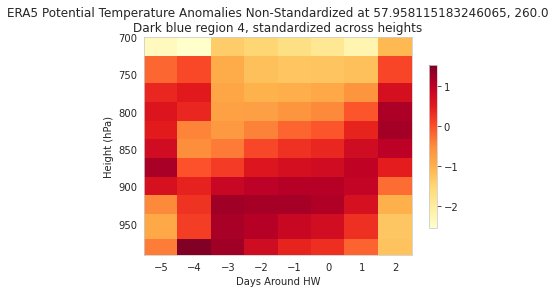

In [55]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 4, standardized across heights')

In [83]:
lat, lon = dblue_coords[4]
lon = lon+360

temp_anoms_lb0,hwdays_lb0, sp = gather_anoms(lat,lon)

levels_above_surface = [level for level in levels if level < sp]
info = { "levels":levels_above_surface,
       "temp_anoms":temp_anoms_lb0}

df_lb0 = pd.DataFrame(info)
df_lb0 = df_lb0.dropna()
t2m_anoms_lb0 = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)

Surface Pressure: 968.5015023951091


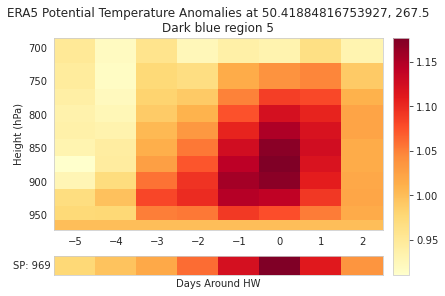

In [84]:
mesh_plot3(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 5')

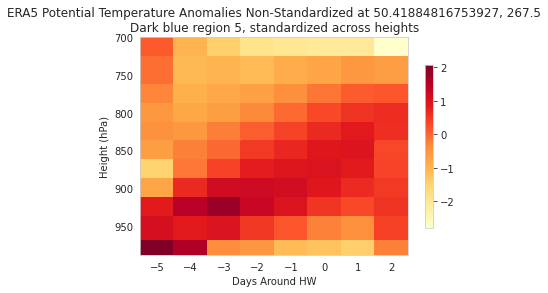

In [57]:
mesh_plot(df_lb0,hwdays_lb0,t2m_anoms_lb0,title='\nDark blue region 5, standardized across heights')

In [13]:
coords = {'-ve SHFLX, +ve LHFLX': lblue_coords, '-ve SHFLX, -ve LHFLX': dblue_coords, 
          '+ve SHFLX, -ve LHFLX': pink_coords, '+ve SHFLX, +ve LHFLX': red_coords}

In [14]:
for i, key in enumerate(coords.keys()):
    print(i, key)

0 -ve SHFLX, +ve LHFLX
1 -ve SHFLX, -ve LHFLX
2 +ve SHFLX, -ve LHFLX
3 +ve SHFLX, +ve LHFLX


Surface Pressure: 838.5219763443237
Surface Pressure: 942.3197206518937
Surface Pressure: 955.9903703100056
Surface Pressure: 981.6633820106065
Surface Pressure: 985.3141454538647
Surface Pressure: 827.711228854487
Surface Pressure: 915.9014964767993
Surface Pressure: 908.2894396494083
Surface Pressure: 971.4847862287381
Surface Pressure: 968.5015023951091
Surface Pressure: 914.4839139023477
Surface Pressure: 807.1943767788475
Surface Pressure: 825.572960311619
Surface Pressure: 1000.7158952435931
Surface Pressure: 985.9539293000547
Surface Pressure: 838.0952964566208
Surface Pressure: 876.3568825410964
Surface Pressure: 937.8167519810963
Surface Pressure: 984.3076660648521
Surface Pressure: 980.4106550850437


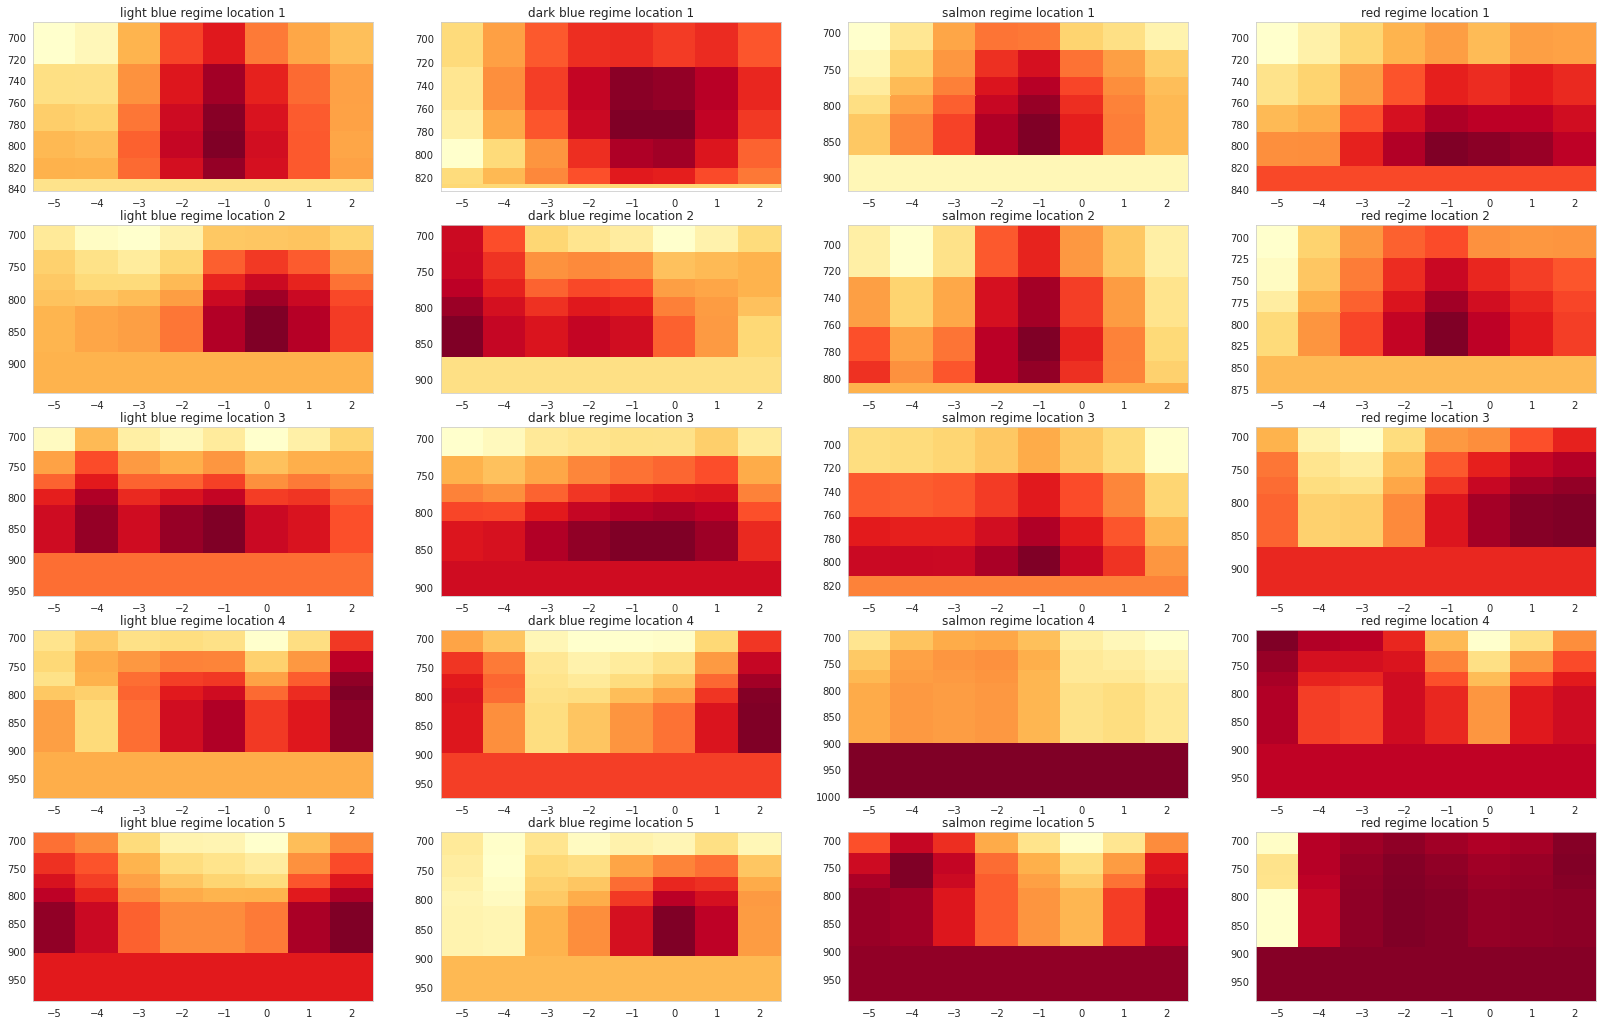

In [56]:
fig, ax = plt.subplots(5, 4, figsize = (28, 18))
  
for col, regime in enumerate(coords.keys()):
    for row, (lat, lon) in enumerate(coords[regime]):
        if lon < 0:
            lon = lon + 360

        temp_anoms, hw_days, sp = gather_anoms(lat,lon)

        levels_above_surface = [level for level in levels if level < sp]
        info = { "levels":levels_above_surface,
               "temp_anoms":temp_anoms}

        df = pd.DataFrame(info)
        df = df.dropna()
        t2m_anoms = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)
        
        surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
        print("Surface Pressure: " + str(surface_pressure))
        temp_anoms = list(df['temp_anoms'])
        levels = list(df['levels'])
        days = np.arange(-5,3)

        ddff = pd.DataFrame(np.nan, index=levels, columns=np.arange(-5,3))

        for lev in range(len(levels)):
            pressure = levels[lev]
            data = pd.Series(np.nan,index=days)
            tp_anoms = temp_anoms[lev]*(1000/pressure)**(0.286)

            for i in np.arange(len(days)): # for day before / after heatwave
                day = days[i]
                data[day] = tp_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
                
            ddff.iloc[lev,:] = data.values

        data = pd.Series(np.nan,index=days)
        for i in np.arange(len(days)):
            day = days[i]
            data[day] = t2m_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
        

        save_ind = np.array(ddff.index)
        new_ind = np.insert(save_ind,[0], (surface_pressure))
        ddff = ddff.iloc[::-1]
        ddff = ddff.append(data, ignore_index=True)
        ddff = ddff.set_index(new_ind[::-1])
        ddff = ddff.sort_index(ascending=True)
#         ind = ddff.index <=surface_pressure
#         ddff = ddff.iloc[ind,:]

        lastrow = ddff.iloc[len(ddff)-1,:]
        ddff = ddff / lastrow

        cmap = plt.cm.get_cmap('YlOrRd')

        cm = ax[row, col].pcolormesh(np.array(ddff.columns) ,np.array(ddff.index), ddff, cmap=cmap, shading='auto')
        ax[row, col].set_ylim(ddff.index[0]-14, ddff.index[-1] + 4 )
        ax[row, col].invert_yaxis()
        ax[row, col].axes.xaxis.set_visible(True)

#         ax[row, col].colorbar(cm, cax=f2_ax3)
        
        ax[row, col].set_title(regime + ' regime location ' + str(row+1))

Surface Pressure: 838.5219763443237
Surface Pressure: 942.3197206518937
Surface Pressure: 955.9903703100056
Surface Pressure: 981.6633820106065
Surface Pressure: 985.3141454538647
Surface Pressure: 827.711228854487
Surface Pressure: 915.9014964767993
Surface Pressure: 908.2894396494083
Surface Pressure: 971.4847862287381
Surface Pressure: 968.5015023951091
Surface Pressure: 914.4839139023477
Surface Pressure: 807.1943767788475
Surface Pressure: 825.572960311619
Surface Pressure: 1000.7158952435931
Surface Pressure: 985.9539293000547
Surface Pressure: 838.0952964566208
Surface Pressure: 876.3568825410964
Surface Pressure: 937.8167519810963
Surface Pressure: 984.3076660648521
Surface Pressure: 980.4106550850437


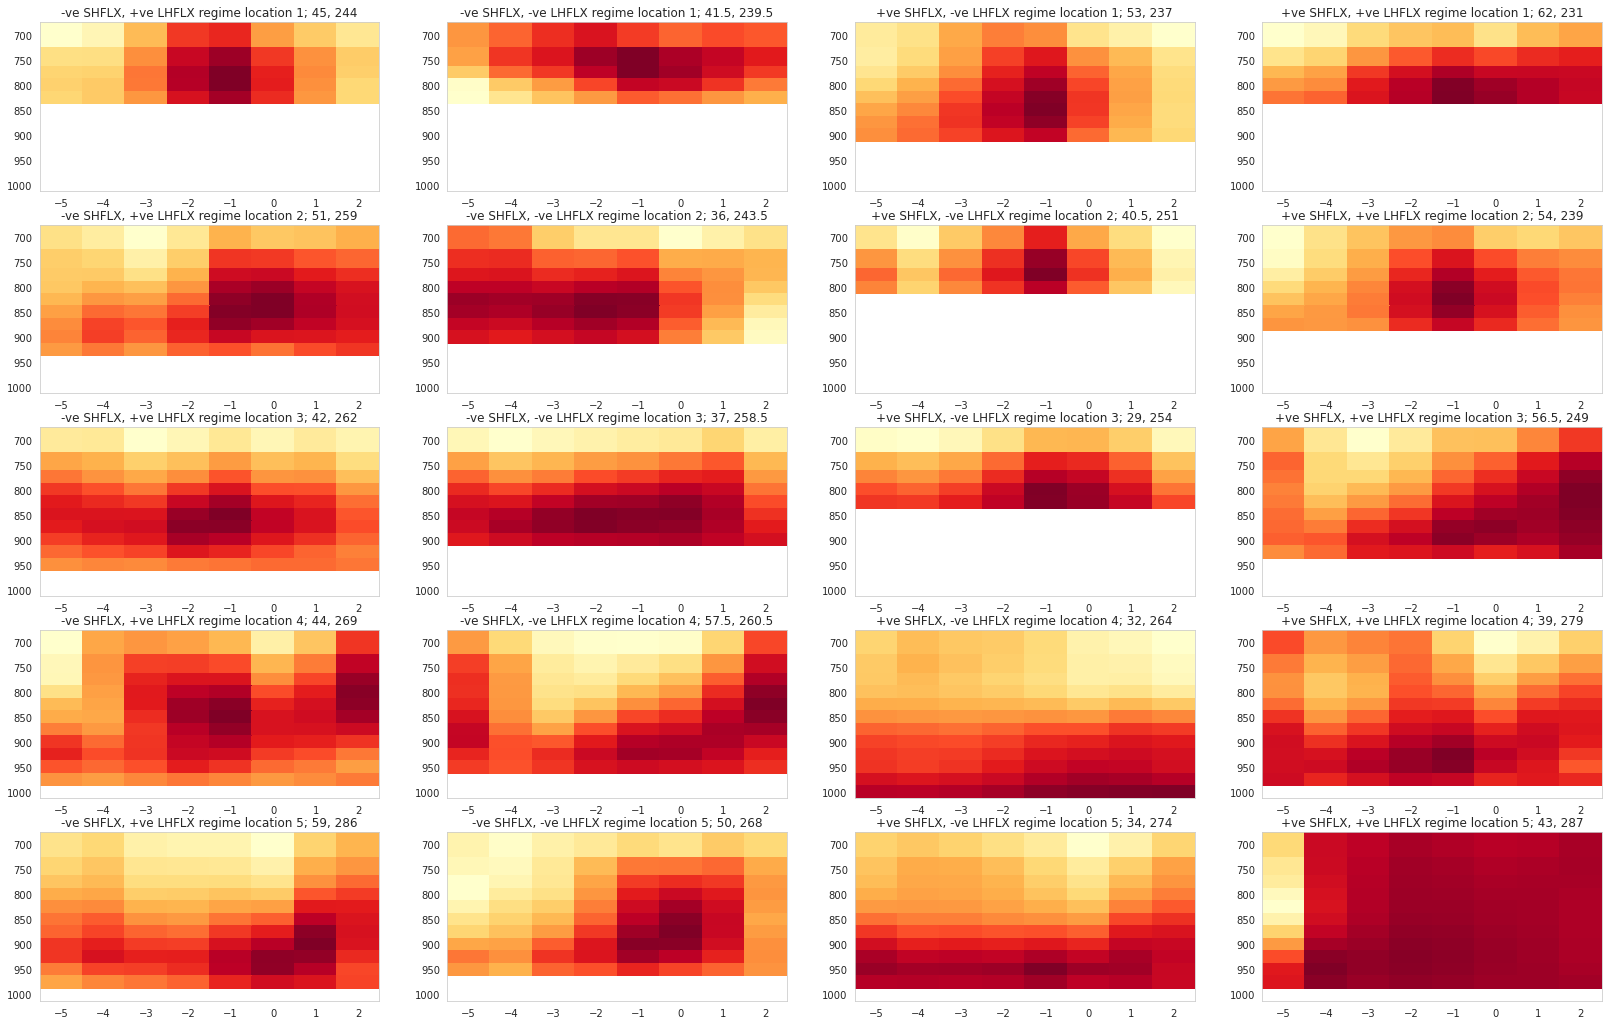

In [36]:
fig, ax = plt.subplots(5, 4, figsize = (28, 18))
  
for col, regime in enumerate(coords.keys()):
    for row, (lat, lon) in enumerate(coords[regime]):
        if lon < 0:
            lon = lon + 360

        temp_anoms, hw_days, sp = gather_anoms(lat,lon)

#         levels_above_surface = [level for level in levels if level < sp]
        info = { "levels":levels,
               "temp_anoms":temp_anoms}

        df = pd.DataFrame(info)
#         df = df.dropna()
        t2m_anoms = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)
        
#         surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
        print("Surface Pressure: " + str(sp))
        temp_anoms = list(df['temp_anoms'])
        
        levels = list(df['levels'])
        days = np.arange(-5,3)

        ddff = pd.DataFrame(np.nan, index=levels, columns=days)

        for lev in range(len(levels)):
            pressure = levels[lev]
            data = pd.Series(np.nan,index=days)
            
            if pressure > sp:
                ddff.iloc[lev,:] = data.values
                continue
            
            tp_anoms = temp_anoms[lev]*(1000/pressure)**(0.286)

            for i in np.arange(len(days)): # for day before / after heatwave
                day = days[i]
                data[day] = tp_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
                
            ddff.iloc[lev,:] = data.values

        data = pd.Series(np.nan,index=days)
        for i in np.arange(len(days)):
            day = days[i]
            data[day] = t2m_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
        

#         save_ind = np.array(ddff.index)
#         new_ind = np.insert(save_ind,[0], (surface_pressure))
#         ddff = ddff.iloc[::-1]
#         ddff = ddff.append(data, ignore_index=True)
#         ddff = ddff.set_index(new_ind[::-1])
#         ddff = ddff.sort_index(ascending=True)
#         ind = ddff.index <=surface_pressure
#         ddff = ddff.iloc[ind,:]

#         lastrow = ddff.iloc[len(ddff)-1,:]
        ddff = ddff / data

        cmap = plt.cm.get_cmap('YlOrRd')

        cm = ax[row, col].pcolormesh(np.array(ddff.columns) ,np.array(ddff.index), ddff, cmap=cmap, shading='auto')
#         ax[row, col].set_ylim(ddff.index[0]-14, ddff.index[-1] + 4 )
        ax[row, col].invert_yaxis()
        ax[row, col].axes.xaxis.set_visible(True)

#         ax[row, col].colorbar(cm, cax=f2_ax3)
        
        ax[row, col].set_title(regime + ' regime location ' + str(row+1) + '; {}, {}'.format(lat, lon) )

Surface Pressure: 838.5219763443237
Surface Pressure: 942.3197206518937
Surface Pressure: 955.9903703100056
Surface Pressure: 981.6633820106065
Surface Pressure: 985.3141454538647
Surface Pressure: 827.711228854487
Surface Pressure: 915.9014964767993
Surface Pressure: 908.2894396494083
Surface Pressure: 971.4847862287381
Surface Pressure: 968.5015023951091
Surface Pressure: 914.4839139023477
Surface Pressure: 807.1943767788475
Surface Pressure: 825.572960311619
Surface Pressure: 1000.7158952435931
Surface Pressure: 985.9539293000547
Surface Pressure: 838.0952964566208
Surface Pressure: 876.3568825410964
Surface Pressure: 937.8167519810963
Surface Pressure: 984.3076660648521
Surface Pressure: 980.4106550850437


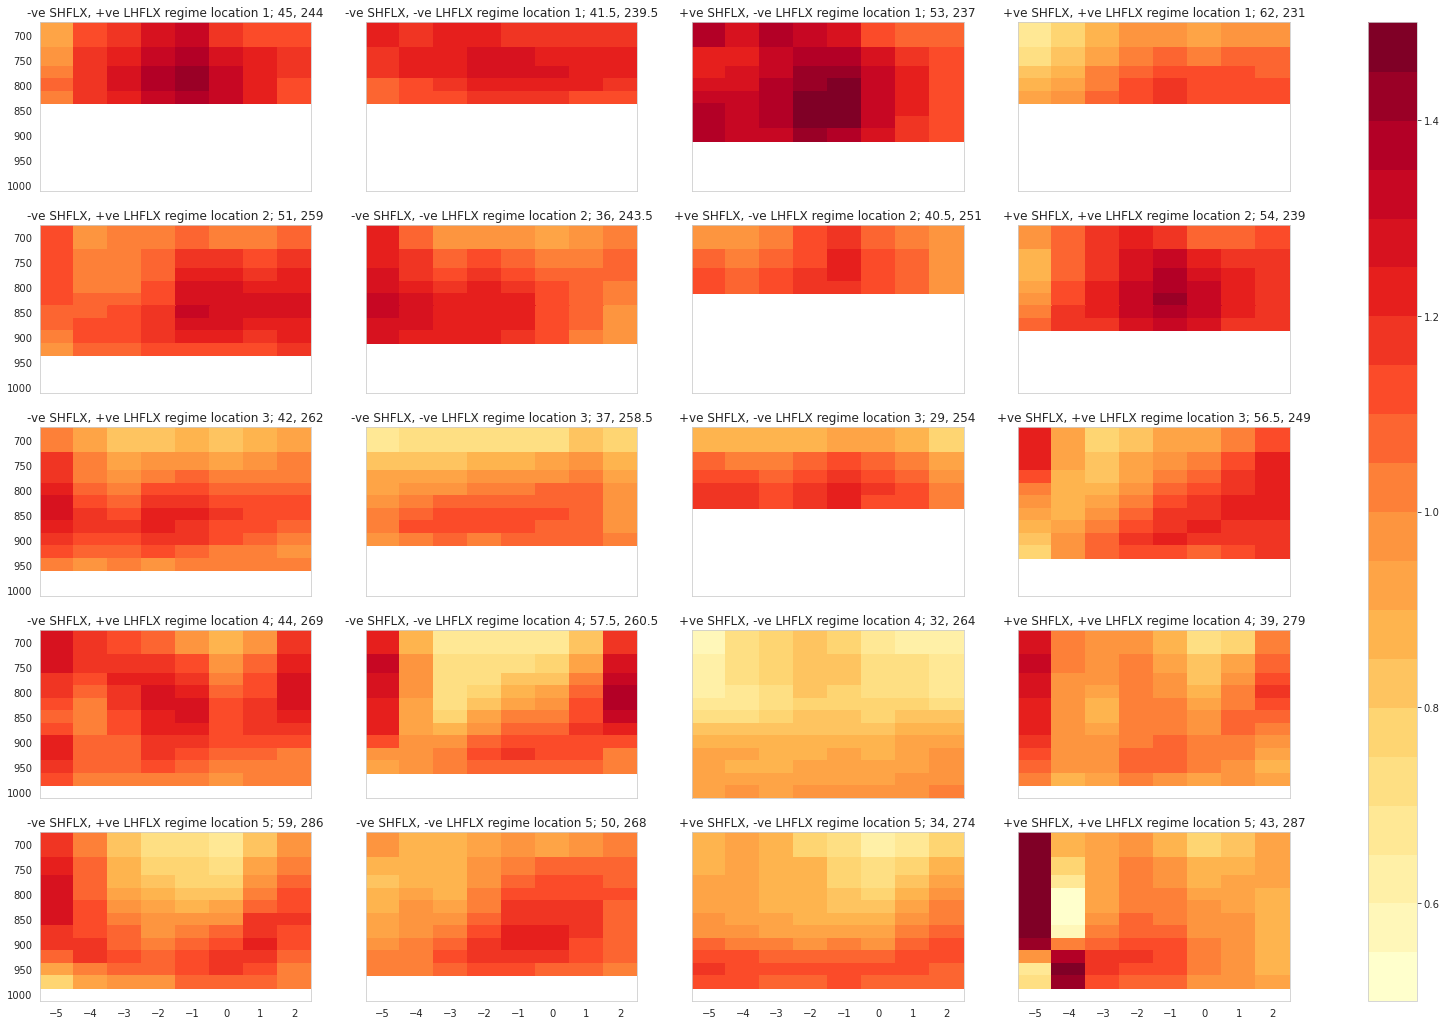

In [30]:
fig, ax = plt.subplots(5, 4, figsize = (28, 18), sharex=True, sharey=True)
ax[0,0].invert_yaxis()
    
for col, regime in enumerate(coords.keys()):
    for row, (lat, lon) in enumerate(coords[regime]):
        if lon < 0:
            lon = lon + 360

        temp_anoms, hw_days, sp = gather_anoms(lat,lon)
        
        info = { "levels":levels,
               "temp_anoms":temp_anoms}
        df = pd.DataFrame(info)
        
        t2m_anoms = get_temperature_anoms(t2m.sel(dict(lat=lat,lon=lon),method='nearest').t2m)
        
        print("Surface Pressure: " + str(sp))
        
        temp_anoms = list(df['temp_anoms'])
        
        levels = list(df['levels'])
        days = np.arange(-5,3)
        ddff = pd.DataFrame(np.nan, index=levels, columns=days)

        for lev in range(len(levels)):
            pressure = levels[lev]
            data = pd.Series(np.nan,index=days)
            
            if pressure > sp:
                ddff.iloc[lev,:] = data.values
                continue
            
            tp_anoms = temp_anoms[lev]*(1000/pressure)**(0.286)

            for i in np.arange(len(days)): 
                day = days[i]
                data[day] = tp_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()
                
            ddff.iloc[lev,:] = data.values

        data = pd.Series(np.nan,index=days)
        for i in np.arange(len(days)):
            day = days[i]
            data[day] = t2m_anoms.sel(time = hw_days + np.timedelta64(day,'D')).mean().item()

        ddff = ddff / data

        cmap = plt.cm.get_cmap('YlOrRd', 20)
        
        cm = ax[row, col].pcolormesh(np.array(ddff.columns) ,np.array(ddff.index), ddff, cmap=cmap, 
                                     vmin=0.5, vmax=1.5, shading='auto')
#         ax[row, col].invert_yaxis()
        ax[row, col].axes.xaxis.set_visible(True)        
        
        ax[row, col].set_title(regime + ' regime location ' + str(row+1) + '; {}, {}'.format(lat, lon) )
        
fig.colorbar(cm, ax=ax.ravel().tolist())